
隐式格式时间收敛性分析 (固定Nx=10000)
| Nt | 最大误差 | 收敛阶 |
|-|-|-|
| 10 | 2.8437e-02 | — |
| 20 | 1.4390e-02 | 9.8267e-01 |
| 40 | 7.2383e-03 | 9.9137e-01 |
| 80 | 3.6300e-03 | 9.9569e-01 |
| 160 | 1.8177e-03 | 9.9785e-01 |

CN格式时间收敛性分析 (固定Nx=10000)
| Nt | 最大误差 | 收敛阶 |
|-|-|-|
| 10 | 4.7905e-04 | — |
| 20 | 1.1977e-04 | 1.9999e+00 |
| 40 | 2.9944e-05 | 2.0000e+00 |
| 80 | 7.4857e-06 | 2.0001e+00 |
| 160 | 1.8711e-06 | 2.0003e+00 |

显式格式时间收敛性分析 (固定Nx=200)
| Nt | 最大误差 | 收敛阶 |
|-|-|-|
| 800 | 3.6305e-04 | — |
| 1600 | 1.8101e-04 | 1.0041e+00 |
| 3200 | 9.0138e-05 | 1.0058e+00 |
| 6400 | 4.4967e-05 | 1.0033e+00 |

隐式格式空间收敛性分析 (固定Nt=100000)
| Nx | 最大误差 | 收敛阶 |
|-|-|-|
| 20 | 6.9539e-04 | — |
| 40 | 1.6810e-04 | 2.0485e+00 |
| 80 | 4.2359e-05 | 1.9886e+00 |
| 160 | 1.1782e-05 | 1.8461e+00 |

CN格式空间收敛性分析 (固定Nt=100000)
| Nx | 最大误差 | 收敛阶 |
|-|-|-|
| 20 | 6.9362e-04 | — |
| 40 | 1.6638e-04 | 2.0596e+00 |
| 80 | 4.0687e-05 | 2.0319e+00 |
| 160 | 1.0052e-05 | 2.0171e+00 |

显式格式空间收敛性分析 (自动调整τ)
| Nx | 最大误差 | 收敛阶

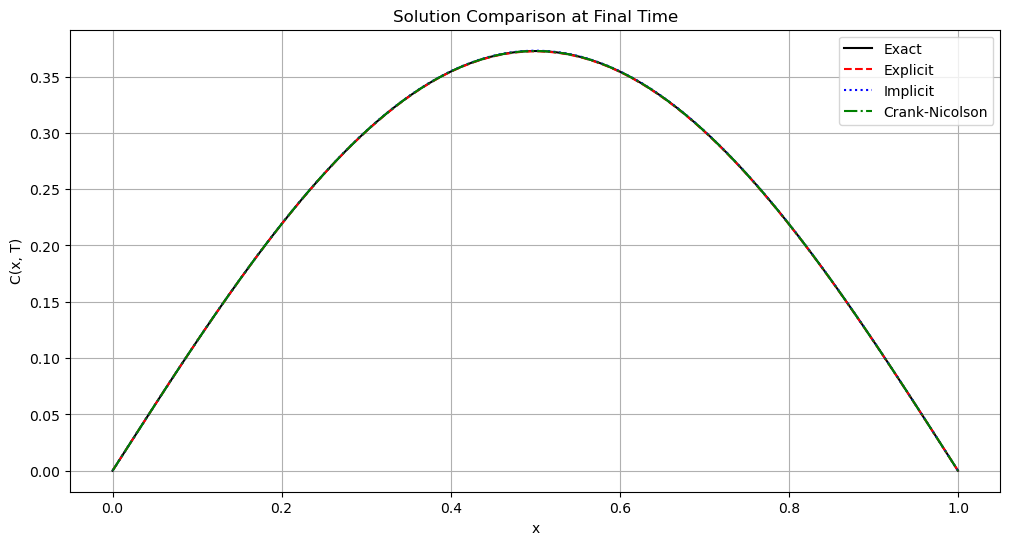

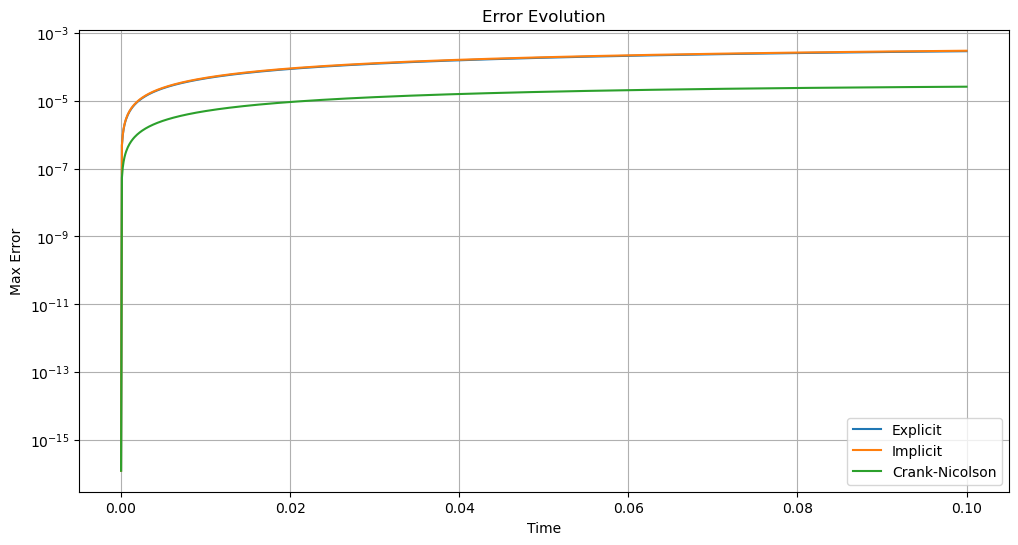

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from time import time

plt.rcParams['font.sans-serif'] = ['SimHei']	# 显示中文
plt.rcParams['axes.unicode_minus'] = False		# 显示负号

#--------------------------------------------------------------------
# 精确解和源项定义
#--------------------------------------------------------------------
def exact_solution(x, t):
    return np.exp(-np.pi**2 * t) * np.sin(np.pi * x)

def source_term(x, t, D, u):
    term1 = -(np.pi**2)*(1-D)*np.exp(-np.pi**2*t)*np.sin(np.pi*x)
    term2 = np.pi*u*np.exp(-np.pi**2*t)*np.cos(np.pi*x)
    return term1 + term2

#--------------------------------------------------------------------
# 数值求解器类
#--------------------------------------------------------------------
class ConvDiffSolver:
    def __init__(self, u=1.0, D=0.1, L=1.0, T=0.1):
        self.u = u          # 对流速度
        self.D = D          # 扩散系数
        self.L = L          # 空间域长度
        self.T = T          # 终止时间
        
    def solve(self, Nx=100, Nt=1000, scheme='explicit'):
        # 网格参数
        h = self.L/(Nx-1)
        tau = self.T/Nt
        x = np.linspace(0, self.L, Nx)
        t = np.linspace(0, self.T, Nt+1)
        
        # 初始化
        C = np.zeros((Nx, Nt+1))
        C[:, 0] = np.sin(np.pi * x)  # 初始条件
        C[0, :] = 0.0                # 左边界
        C[-1, :] = 0.0               # 右边界
        
        if scheme == 'explicit':
            self._solve_explicit(C, h, tau, Nx, Nt, x, t)
        elif scheme == 'implicit':
            self._solve_implicit(C, h, tau, Nx, Nt, x, t)
        elif scheme == 'CN':
            self._solve_cn(C, h, tau, Nx, Nt, x, t)
            
        return x, t, C
    
    def _solve_explicit(self, C, h, tau, Nx, Nt, x, t):
        r = self.D * tau / h**2
        c = self.u * tau / (2*h)
        for n in range(Nt):
            for i in range(1, Nx-1):
                C[i, n+1] = C[i, n] \
                    - c*(C[i+1, n] - C[i-1, n]) \
                    + r*(C[i+1, n] - 2*C[i, n] + C[i-1, n]) \
                    + tau*source_term(x[i], t[n], self.D, self.u)
            # 显式格式稳定性检查
            if r > 0.5:
                # 抛出错误
                raise ValueError(f"显式格式不稳定 (r={r:.3f} > 0.5)")
                
    def _solve_implicit(self, C, h, tau, Nx, Nt, x, t):
        size = Nx - 2
        r = self.D * tau / h**2
        c = self.u * tau / (2*h)
        
        # 构建三对角矩阵
        main_diag = np.ones(size)*(1 + 2*r)
        lower_diag = np.ones(size-1)*(-r - c)
        upper_diag = np.ones(size-1)*(-r + c)
        
        A = diags([lower_diag, main_diag, upper_diag], 
                  [-1, 0, 1], shape=(size, size), format='csr')
        
        for n in range(Nt):
            rhs = C[1:-1, n] + tau*source_term(x[1:-1], t[n+1], self.D, self.u)
            C[1:-1, n+1] = spsolve(A, rhs)
            
    def _solve_cn(self, C, h, tau, Nx, Nt, x, t):
        size = Nx - 2
        r = self.D * tau / (2*h**2)
        c = self.u * tau / (4*h)
        
        # 构建系数矩阵
        main_diag = np.ones(size)*(1 + 2*r)
        lower_diag = np.ones(size-1)*(-r - c)
        upper_diag = np.ones(size-1)*(-r + c)
        A = diags([lower_diag, main_diag, upper_diag],
                  [-1, 0, 1], shape=(size, size), format='csr')
        
        for n in range(Nt):
            # 显式部分
            explicit = C[1:-1, n] \
                - c*(C[2:, n] - C[:-2, n]) \
                + r*(C[2:, n] - 2*C[1:-1, n] + C[:-2, n]) \
                + 0.5*tau*(source_term(x[1:-1], t[n], self.D, self.u) \
                          + source_term(x[1:-1], t[n+1], self.D, self.u))
            
            C[1:-1, n+1] = spsolve(A, explicit)

#--------------------------------------------------------------------
# 收敛性分析工具
#--------------------------------------------------------------------
def analyze_temporal_convergence(solver, Nt_list, fixed_Nx=1000, scheme='implicit'):
    """时间收敛性分析（固定空间网格）"""
    errors = []
    for Nt in Nt_list:
        x, t, C = solver.solve(Nx=fixed_Nx, Nt=Nt, scheme=scheme)
        exact = exact_solution(x[:, None], t[None, :])
        max_error = np.max(np.abs(C - exact))
        errors.append(max_error)
    
    orders = []
    for i in range(1, len(errors)):
        tau_ratio = Nt_list[i]/Nt_list[i-1]  # τ比例
        order = np.log(errors[i-1]/errors[i])/np.log(tau_ratio)
        orders.append(order)
    return errors, orders

def analyze_spatial_convergence(solver, Nx_list, fixed_Nt=10000, scheme='implicit'):
    """空间收敛性分析（固定时间步长）"""
    errors = []
    for Nx in Nx_list:
        x, t, C = solver.solve(Nx=Nx, Nt=fixed_Nt, scheme=scheme)
        exact = exact_solution(x[:, None], t[None, :])
        max_error = np.max(np.abs(C - exact))
        errors.append(max_error)
    
    orders = []
    for i in range(1, len(errors)):
        h_ratio = Nx_list[i]/Nx_list[i-1]  # h比例
        order = np.log(errors[i-1]/errors[i])/np.log(h_ratio)
        orders.append(order)
    return errors, orders

def analyze_explicit_spatial_convergence(solver, Nx_list):
    """显式格式空间收敛性分析（自动调整时间步长以满足稳定性条件）"""
    errors = []
    for Nx in Nx_list:
        h = solver.L / (Nx - 1)
        # 计算满足稳定性条件的时间步长
        max_r = 0.5  # 显式格式稳定性条件
        tau = max_r * h**2 / solver.D
        Nt = max(int(np.ceil(solver.T / tau)), 1000)  # 防止Nt过小
        
        x, t, C = solver.solve(Nx=Nx, Nt=Nt, scheme='explicit')
        exact = exact_solution(x[:, None], t[None, :])
        max_error = np.max(np.abs(C - exact))
        errors.append(max_error)
    
    # 计算空间收敛阶
    orders = []
    for i in range(1, len(errors)):
        h_ratio = (solver.L/(Nx_list[i-1]-1)) / (solver.L/(Nx_list[i]-1))  # h_prev/h_current
        order = np.log(errors[i-1]/errors[i]) / np.log(h_ratio)
        orders.append(order)
    return errors, orders

#--------------------------------------------------------------------
# 稳定性测试
#--------------------------------------------------------------------
def stability_test(solver):
    """显式格式稳定性测试"""
    test_cases = [
        {'h': 0.1, 'tau': 0.005, 'r': 0.5},    # 稳定边界
        {'h': 0.05, 'tau': 0.0025, 'r': 0.5},  # 稳定
        {'h': 0.04, 'tau': 0.1, 'r': 0.625}  # 不稳定
    ]
    
    print("\n稳定性测试:")
    for case in test_cases:
        h = case['h']
        tau = case['tau']
        Nx = int(solver.L/h) + 1
        Nt = int(solver.T/tau)
        print(f"测试 h={h:.3f}, τ={tau:.4f}, r={case['r']:.3f}")
        
        try:
            x, t, C = solver.solve(Nx=Nx, Nt=Nt, scheme='explicit')
            exact = exact_solution(x[:, None], t[None, :])
            error = np.max(np.abs(C - exact))
            print(f"最大误差: {error:.4e} (稳定)")
        except Exception as e:
            print(f"数值不稳定: {str(e)}")

#--------------------------------------------------------------------
# 结果表格生成
#--------------------------------------------------------------------
def print_convergence_table(data, headers):
    """通用表格打印函数"""
    print("\n" + "="*60)
    print(f"{headers['title']}")
    print("| "+" | ".join(headers['columns'])+" |")
    print("|"+"-|"*len(headers['columns']))
    
    for row in data:
        print("| "+" | ".join([f"{x:.4e}" if isinstance(x, float) else str(x) for x in row])+" |")

#--------------------------------------------------------------------
# 主程序
#--------------------------------------------------------------------
if __name__ == "__main__":
    # 初始化求解器
    solver = ConvDiffSolver(u=1.0, D=0.1, T=0.1)
    
    # ==================== 基本求解与可视化 ====================
    # 基本求解
    Nx, Nt = 100, 1000
    x, t, C_explicit = solver.solve(Nx=Nx, Nt=Nt, scheme='explicit')
    _, _, C_implicit = solver.solve(Nx=Nx, Nt=Nt, scheme='implicit')
    _, _, C_cn = solver.solve(Nx=Nx, Nt=Nt, scheme='CN')
    
    # 计算精确解
    exact = exact_solution(x[:, None], t[None, :])
    
    # 绘制最终时刻解的比较
    plt.figure(figsize=(12, 6))
    plt.plot(x, exact[:, -1], 'k-', label='精确解')
    plt.plot(x, C_explicit[:, -1], 'r--', label='显式')
    plt.plot(x, C_implicit[:, -1], 'b:', label='隐式')
    plt.plot(x, C_cn[:, -1], 'g-.', label='Crank-Nicolson')
    plt.xlabel('x')
    plt.ylabel('C(x, T)')
    plt.title('最终时刻解的比较')
    plt.legend()
    plt.grid(True)
    
    # 误差随时间变化
    plt.figure(figsize=(12, 6))
    plt.semilogy(t, np.max(np.abs(C_explicit - exact), axis=0), label='显式')
    plt.semilogy(t, np.max(np.abs(C_implicit - exact), axis=0), label='隐式')
    plt.semilogy(t, np.max(np.abs(C_cn - exact), axis=0), label='Crank-Nicolson')
    plt.xlabel('时间')
    plt.ylabel('最大误差')
    plt.title('误差随时间演变')
    plt.legend()
    plt.grid(True)

    
    # ==================== 收敛性分析 ====================
    # 时间收敛分析
    Nt_list = [10, 20, 40, 80, 160]
    fixed_Nx = 10000
    
    # 隐式格式
    errors_implicit_time, orders_implicit_time = analyze_temporal_convergence(
        solver, Nt_list, fixed_Nx, 'implicit')
    print_convergence_table(
        data=[[Nt_list[i], errors_implicit_time[i], orders_implicit_time[i-1] if i>0 else '—'] 
              for i in range(len(Nt_list))],
        headers={
            'title': '隐式格式时间收敛性分析 (固定Nx=10000)',
            'columns': ['Nt', '最大误差', '收敛阶']
        }
    )
    
    # CN格式
    errors_cn_time, orders_cn_time = analyze_temporal_convergence(
        solver, Nt_list, fixed_Nx, 'CN')
    print_convergence_table(
        data=[[Nt_list[i], errors_cn_time[i], orders_cn_time[i-1] if i>0 else '—'] 
              for i in range(len(Nt_list))],
        headers={
            'title': 'CN格式时间收敛性分析 (固定Nx=10000)',
            'columns': ['Nt', '最大误差', '收敛阶']
        }
    )
    
    # 显式格式（需要满足稳定性条件）
    fixed_Nx_explicit = 200
    Nt_list_explicit = [800, 1600, 3200, 6400]
    errors_explicit_time, orders_explicit_time = analyze_temporal_convergence(
        solver, Nt_list_explicit, fixed_Nx_explicit, 'explicit')
    print_convergence_table(
        data=[[Nt_list_explicit[i], errors_explicit_time[i], orders_explicit_time[i-1] if i>0 else '—'] 
              for i in range(len(Nt_list_explicit))],
        headers={
            'title': '显式格式时间收敛性分析 (固定Nx=200)',
            'columns': ['Nt', '最大误差', '收敛阶']
        }
    )
    
    # 空间收敛分析
    Nx_list = [20, 40, 80, 160]
    fixed_Nt = 100000
    
    # 隐式格式
    errors_implicit_space, orders_implicit_space = analyze_spatial_convergence(
        solver, Nx_list, fixed_Nt, 'implicit')
    print_convergence_table(
        data=[[Nx_list[i], errors_implicit_space[i], orders_implicit_space[i-1] if i>0 else '—'] 
              for i in range(len(Nx_list))],
        headers={
            'title': '隐式格式空间收敛性分析 (固定Nt=100000)',
            'columns': ['Nx', '最大误差', '收敛阶']
        }
    )
    
    # CN格式
    errors_cn_space, orders_cn_space = analyze_spatial_convergence(
        solver, Nx_list, fixed_Nt, 'CN')
    print_convergence_table(
        data=[[Nx_list[i], errors_cn_space[i], orders_cn_space[i-1] if i>0 else '—'] 
              for i in range(len(Nx_list))],
        headers={
            'title': 'CN格式空间收敛性分析 (固定Nt=100000)',
            'columns': ['Nx', '最大误差', '收敛阶']
        }
    )
    
    # 显式格式空间收敛性分析（动态调整时间步长）
    Nx_list_explicit = [20, 40, 80, 160]
    errors_explicit_space, orders_explicit_space = analyze_explicit_spatial_convergence(solver, Nx_list_explicit)

    print_convergence_table(
        data=[[Nx_list_explicit[i], errors_explicit_space[i], orders_explicit_space[i-1] if i>0 else '—'] 
            for i in range(len(Nx_list_explicit))],
        headers={
            'title': '显式格式空间收敛性分析 (自动调整τ)',
            'columns': ['Nx', '最大误差', '收敛阶']
        }
    )
    
    # ==================== 稳定性测试 ====================
    stability_test(solver)

    
    plt.show()

显式格式下 ghost 与 one-sided 方法最大差异： 1.3577e-01

隐式格式时间收敛性分析 (固定 Nx = 1000)
| Nt | 最大误差 | 收敛阶 |
|---|---|---|
| 100 | 2.9986e-03 | — |
| 200 | 1.5006e-03 | 9.9874e-01 |
| 400 | 7.5063e-04 | 9.9937e-01 |
| 800 | 3.7539e-04 | 9.9970e-01 |
| 1600 | 1.8771e-04 | 9.9987e-01 |

隐式格式空间收敛性分析 (固定 Nt = 10000)
| Nx | 最大误差 | 收敛阶 |
|---|---|---|
| 20 | 8.6952e-04 | — |
| 40 | 2.1197e-04 | 1.9628e+00 |
| 80 | 6.1411e-05 | 1.7550e+00 |
| 160 | 3.0010e-05 | 1.0237e+00 |
| 320 | 2.9959e-05 | 2.4674e-03 |

细网格计算 (Nx=2000, Nt=20000) 最大误差： 1.5017e-05

稳定性测试（Explicit）:
测试 h = 0.010, τ = 0.0005
最大误差: 1.5040e-03 (稳定)
测试 h = 0.010, τ = 0.0010
最大误差: 7.2562e+39 (稳定)
测试 h = 0.010, τ = 0.0050
最大误差: 2.3095e+19 (稳定)


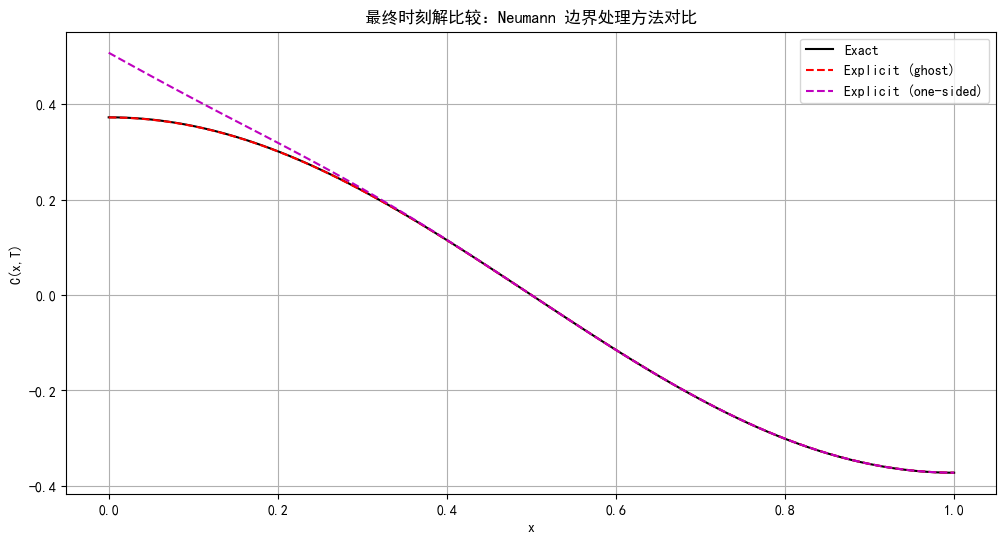

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


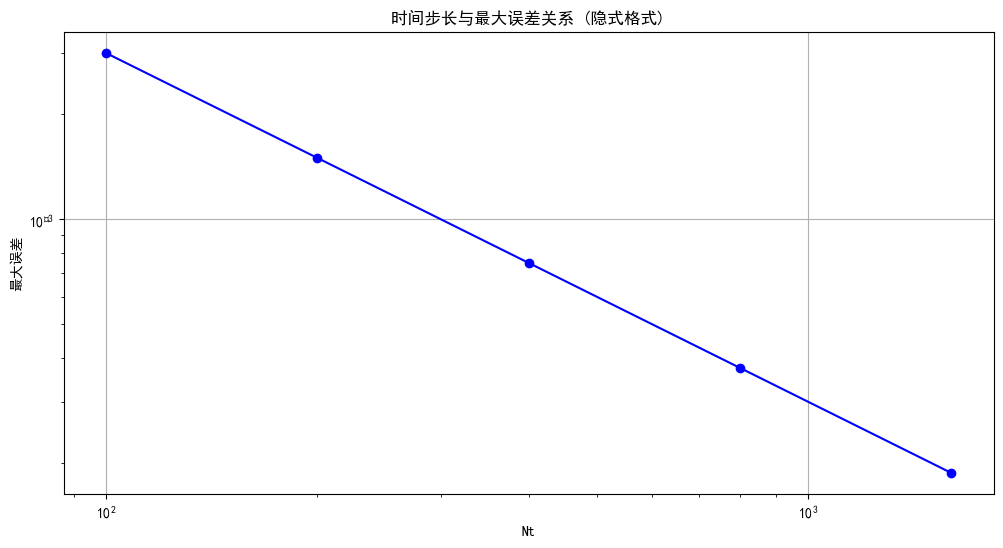

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

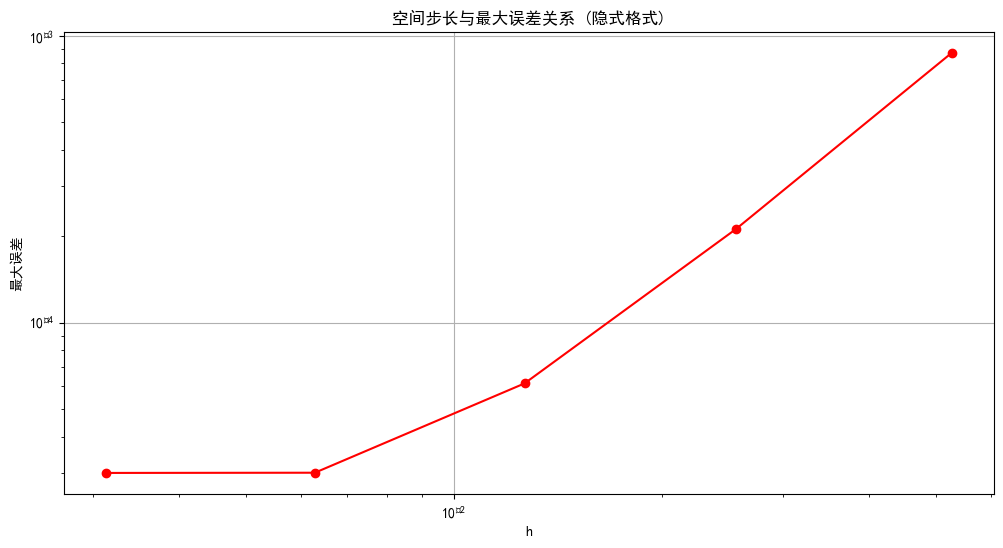

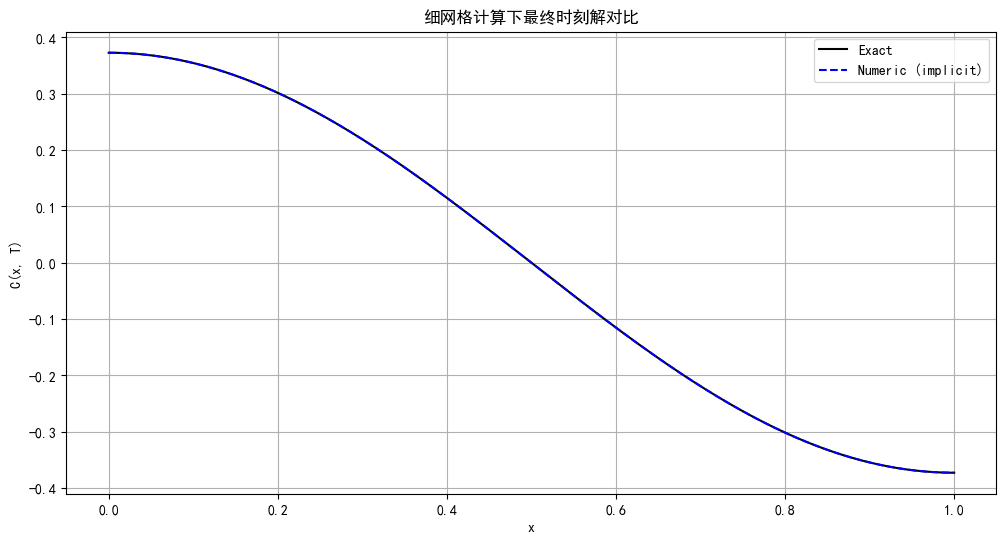

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

plt.rcParams['font.sans-serif'] = ['SimHei']	# 显示中文
plt.rcParams['axes.unicode_minus'] = False		# 显示负号

# ============================================================
# 问题 (2) 精确解、源项及边界/初始条件定义
# ============================================================

def exact_solution_bc2(x, t):
    """
    精确解: C(x,t) = exp(-pi^2*t) * cos(pi*x)
    """
    return np.exp(-np.pi**2 * t) * np.cos(np.pi * x)

def source_term_bc2(x, t, D, u):
    """
    f(x,t) = -pi^2*(1-D)*exp(-pi^2*t)*cos(pi*x) - pi*u*exp(-pi^2*t)*sin(pi*x)
    """
    return - (np.pi**2) * (1 - D) * np.exp(-np.pi**2 * t) * np.cos(np.pi * x) \
           - np.pi * u * np.exp(-np.pi**2 * t) * np.sin(np.pi * x)

def phi_initial(x):
    """初始条件: phi(x) = cos(pi*x)"""
    return np.cos(np.pi * x)

def Phi1(t):
    """左端 Neumann 边界: dC/dx(0,t)=0"""
    return 0.0

def Phi2(t):
    """右端 Dirichlet 边界: C(1,t) = -exp(-pi^2*t)"""
    return -np.exp(-np.pi**2 * t)

# ============================================================
# 求解器类（问题 (2)）
# ============================================================
class ConvDiffSolver_BC2:
    def __init__(self, u=1.0, D=0.1, L=1.0, T=0.1, bc_method='ghost'):
        """
        参数:
          u       : 对流速度
          D       : 扩散系数
          L       : 空间域长度（此处默认为 [0, L]，L=1）
          T       : 终止时间
          bc_method: Neumann 边界处理方法，取值 'ghost' 或 'one-sided'
        """
        self.u = u
        self.D = D
        self.L = L
        self.T = T
        self.bc_method = bc_method

    def solve(self, Nx=100, Nt=1000, scheme='explicit'):
        """
        求解器接口，根据选择的格式（explicit, implicit, CN）计算数值解
        """
        h = self.L / (Nx - 1)
        tau = self.T / Nt
        x = np.linspace(0, self.L, Nx)
        t = np.linspace(0, self.T, Nt + 1)

        # 初始化解数组，并设置初始条件
        C = np.zeros((Nx, Nt + 1))
        C[:, 0] = phi_initial(x)
        # 右端 Dirichlet 边界在所有时间点上都固定
        C[-1, :] = Phi2(t)

        if scheme == 'explicit':
            self._solve_explicit(C, h, tau, Nx, Nt, x, t)
        elif scheme == 'implicit':
            self._solve_implicit(C, h, tau, Nx, Nt, x, t)
        elif scheme == 'CN':
            self._solve_cn(C, h, tau, Nx, Nt, x, t)

        return x, t, C

    # -------------------------------
    # 显式格式（对 Neumann BC 采用两种方法选择）
    # -------------------------------
    def _solve_explicit(self, C, h, tau, Nx, Nt, x, t):
        u = self.u
        D = self.D
        for n in range(Nt):
            # --- 左端 i=0 处处理 Neumann 边界 ---
            if self.bc_method == 'ghost':
                # ghost node 方法：假设 C[-1] = C[1]
                # 则：dC/dx(0) ≈ (C[1]-C[1])/(2h)=0, 
                #      d²C/dx²(0) ≈ (C[1]-2C[0]+C[1])/h² = 2*(C[1]-C[0])/h²
                diffusion = 2 * (C[1, n] - C[0, n]) / h**2
                convection = 0.0  # 自然满足 dC/dx = 0
                C[0, n + 1] = C[0, n] + tau * ( - u * convection + D * diffusion + source_term_bc2(x[0], t[n], D, u) )
            elif self.bc_method == 'one-sided':
                # 单侧差分：利用前向差分近似 dC/dx 和一侧差分近似二阶导数
                if Nx < 4:
                    raise ValueError("对于 one-sided 方法，Nx 必须>=4")
                convection = (C[1, n] - C[0, n]) / h  # 前向差分
                # 采用二阶精度的一侧差分公式： u''(0) ≈ (-2*u0 + 5*u1 - 4*u2 + u3)/h²
                diffusion = (-2 * C[0, n] + 5 * C[1, n] - 4 * C[2, n] + C[3, n]) / h**2
                C[0, n + 1] = C[0, n] + tau * ( - u * convection + D * diffusion + source_term_bc2(x[0], t[n], D, u) )
            # --- 内部节点 i=1,...,Nx-2 用中心差分 ---
            for i in range(1, Nx - 1):
                convection = (C[i + 1, n] - C[i - 1, n]) / (2 * h)
                diffusion = (C[i + 1, n] - 2 * C[i, n] + C[i - 1, n]) / h**2
                C[i, n + 1] = C[i, n] + tau * ( - u * convection + D * diffusion + source_term_bc2(x[i], t[n], D, u) )
            # --- 右端 Dirichlet 边界 ---
            C[-1, n + 1] = Phi2(t[n + 1])

    # -------------------------------
    # 隐式格式（采用 ghost node 方法处理 Neumann BC）
    # -------------------------------
    def _solve_implicit(self, C, h, tau, Nx, Nt, x, t):
        u = self.u
        D = self.D
        r = D * tau / h**2
        c = u * tau / (2 * h)
        # 未知数：全局节点 0 到 Nx-2（因为 i=Nx-1 由 Dirichlet 条件给出）
        size = Nx - 1

        # 构造三对角矩阵 A
        # 对于 i=0（左端，采用 ghost node 得到的离散格式）： 
        # (C₀ⁿ⁺¹ - C₀ⁿ)/τ = D * [2*(C₁ⁿ⁺¹ - C₀ⁿ⁺¹)/h²] + f(0, tⁿ⁺¹)
        # 故第 0 行：主对角元 = 1 + 2r, 上对角元 = -2r
        main_diag = [1 + 2 * r]
        upper_diag = [-2 * r]
        # 对于 i = 1,2,...,size-1（对应全局 i=1,...,Nx-2）采用标准中心差分
        for i in range(1, size):
            main_diag.append(1 + 2 * r)
            upper_diag.append(- (r - c))
        lower_diag = [0]  # 第 0 行无下对角元
        for i in range(1, size):
            lower_diag.append(- (r + c))
        # 构造矩阵（注意：第一行只有主对角和上对角；后续行为三对角）
        A = diags([lower_diag[1:], main_diag, upper_diag[:-1]], offsets=[-1, 0, 1],
                  shape=(size, size), format='csr')

        for n in range(Nt):
            rhs = np.zeros(size)
            # 第 0 行 (全局 i=0)
            rhs[0] = C[0, n] + tau * source_term_bc2(x[0], t[n + 1], D, u)
            # i = 1,...,size-1（对应全局 i=1,...,Nx-2）
            for i in range(1, size):
                rhs[i] = C[i, n] + tau * source_term_bc2(x[i], t[n + 1], D, u)
            # 对于最后一行（全局 i = Nx-2），上差项涉及已知右端值 C[Nx-1] = Phi2(t)
            rhs[-1] += (r - c) * Phi2(t[n + 1])

            sol = spsolve(A, rhs)
            C[:size, n + 1] = sol
            C[-1, n + 1] = Phi2(t[n + 1])

    # -------------------------------
    # Crank–Nicolson 格式（采用 ghost node 方法处理 Neumann BC）
    # -------------------------------
    def _solve_cn(self, C, h, tau, Nx, Nt, x, t):
        u = self.u
        D = self.D
        # CN 格式中，时间项系数减半
        r_CN = D * tau / (2 * h**2)
        c_CN = u * tau / (4 * h)
        size = Nx - 1  # 未知数为全局 i=0,...,Nx-2

        # 构造隐式部分的三对角矩阵 A
        main_diag = [1 + 2 * r_CN]
        upper_diag = [-2 * r_CN]
        for i in range(1, size):
            main_diag.append(1 + 2 * r_CN)
            upper_diag.append(- (r_CN - c_CN))
        lower_diag = [0]
        for i in range(1, size):
            lower_diag.append(- (r_CN + c_CN))
        A = diags([lower_diag[1:], main_diag, upper_diag[:-1]], offsets=[-1, 0, 1],
                  shape=(size, size), format='csr')

        for n in range(Nt):
            rhs = np.zeros(size)
            # --- 第 0 行 (全局 i=0) ---
            # 显式部分：利用 ghost node 处理
            explicit_0 = C[0, n] + 2 * r_CN * (C[1, n] - C[0, n]) \
                         + 0.5 * tau * (source_term_bc2(x[0], t[n], D, u) + source_term_bc2(x[0], t[n + 1], D, u))
            rhs[0] = explicit_0
            # --- 内部节点 i = 1,...,size-1 (全局 i=1,...,Nx-2) ---
            for i in range(1, size):
                explicit_i = C[i, n] - c_CN * (C[i + 1, n] - C[i - 1, n]) \
                             + r_CN * (C[i + 1, n] - 2 * C[i, n] + C[i - 1, n]) \
                             + 0.5 * tau * (source_term_bc2(x[i], t[n], D, u) + source_term_bc2(x[i], t[n + 1], D, u))
                rhs[i] = explicit_i
            # 对最后一行（全局 i = Nx-2）调整右端项，因 C[Nx-1] 已知
            rhs[-1] += (r_CN - c_CN) * Phi2(t[n + 1])

            sol = spsolve(A, rhs)
            C[:size, n + 1] = sol
            C[-1, n + 1] = Phi2(t[n + 1])

# ============================================================
# 数值测试分析工具
# ============================================================

def analyze_temporal_convergence_bc2(solver, Nt_list, fixed_Nx=1000, scheme='implicit'):
    """
    时间收敛性分析（固定空间网格）
    """
    errors = []
    for Nt in Nt_list:
        x, t, C = solver.solve(Nx=fixed_Nx, Nt=Nt, scheme=scheme)
        exact = exact_solution_bc2(x[:, None], t[None, :])
        max_error = np.max(np.abs(C - exact))
        errors.append(max_error)
    orders = []
    for i in range(1, len(errors)):
        tau_ratio = Nt_list[i] / Nt_list[i - 1]
        order = np.log(errors[i - 1] / errors[i]) / np.log(tau_ratio)
        orders.append(order)
    return errors, orders

def analyze_spatial_convergence_bc2(solver, Nx_list, fixed_Nt=10000, scheme='implicit'):
    """
    空间收敛性分析（固定时间步长）
    """
    errors = []
    for Nx in Nx_list:
        x, t, C = solver.solve(Nx=Nx, Nt=fixed_Nt, scheme=scheme)
        exact = exact_solution_bc2(x[:, None], t[None, :])
        max_error = np.max(np.abs(C - exact))
        errors.append(max_error)
    orders = []
    for i in range(1, len(errors)):
        h_prev = solver.L / (Nx_list[i - 1] - 1)
        h_curr = solver.L / (Nx_list[i] - 1)
        h_ratio = h_prev / h_curr
        order = np.log(errors[i - 1] / errors[i]) / np.log(h_ratio)
        orders.append(order)
    return errors, orders

def stability_test_bc2(solver, test_cases, scheme='explicit'):
    """
    显式格式稳定性测试：给定一组 h 与 tau
    """
    print("\n稳定性测试（Explicit）:")
    for case in test_cases:
        h = case['h']
        tau = case['tau']
        Nx = int(solver.L / h) + 1
        Nt = int(solver.T / tau)
        print(f"测试 h = {h:.3f}, τ = {tau:.4f}")
        try:
            x, t, C = solver.solve(Nx=Nx, Nt=Nt, scheme=scheme)
            exact = exact_solution_bc2(x[:, None], t[None, :])
            error = np.max(np.abs(C - exact))
            print(f"最大误差: {error:.4e} (稳定)")
        except Exception as e:
            print(f"数值不稳定: {str(e)}")

def print_convergence_table(data, headers):
    """通用表格打印函数"""
    print("\n" + "=" * 60)
    print(headers['title'])
    header_line = "| " + " | ".join(headers['columns']) + " |"
    print(header_line)
    print("|" + "---|" * len(headers['columns']))
    for row in data:
        row_str = "| " + " | ".join([f"{x:.4e}" if isinstance(x, float) else str(x) for x in row]) + " |"
        print(row_str)

def compare_bc_methods(solver_ghost, solver_onesided, Nx=100, Nt=1000, scheme='explicit'):
    """
    比较 ghost node 与 one-sided 方法下显式格式的结果差异
    """
    x, t, C_ghost = solver_ghost.solve(Nx=Nx, Nt=Nt, scheme=scheme)
    x, t, C_onesided = solver_onesided.solve(Nx=Nx, Nt=Nt, scheme=scheme)
    diff = np.abs(C_ghost - C_onesided)
    max_diff = np.max(diff)
    return max_diff, diff

# ============================================================
# 数值测试与结果可视化（问题 (2)）
# ============================================================
if __name__ == "__main__":
    # -------------------------------
    # 比较两种 Neumann 边界处理方法（显式格式）
    # -------------------------------
    solver_bc2_ghost = ConvDiffSolver_BC2(u=1.0, D=0.1, T=0.1, bc_method='ghost')
    solver_bc2_oneSided = ConvDiffSolver_BC2(u=1.0, D=0.1, T=0.1, bc_method='one-sided')
    Nx = 100
    Nt = 1000

    x, t, C_explicit_ghost = solver_bc2_ghost.solve(Nx=Nx, Nt=Nt, scheme='explicit')
    x, t, C_explicit_onesided = solver_bc2_oneSided.solve(Nx=Nx, Nt=Nt, scheme='explicit')
    max_bc_diff, diff_matrix = compare_bc_methods(solver_bc2_ghost, solver_bc2_oneSided, Nx=Nx, Nt=Nt)
    print(f"显式格式下 ghost 与 one-sided 方法最大差异： {max_bc_diff:.4e}")

    # 绘制两方法在最终时刻的解
    plt.figure(figsize=(12, 6))
    plt.plot(x, exact_solution_bc2(x, t[-1]), 'k-', label='Exact')
    plt.plot(x, C_explicit_ghost[:, -1], 'r--', label='Explicit (ghost)')
    plt.plot(x, C_explicit_onesided[:, -1], 'm--', label='Explicit (one-sided)')
    plt.xlabel('x')
    plt.ylabel('C(x,T)')
    plt.title('最终时刻解比较：Neumann 边界处理方法对比')
    plt.legend()
    plt.grid(True)

    # -------------------------------
    # 截断误差分析：时间收敛性测试（以隐式格式为例）
    # -------------------------------
    Nt_list = [100, 200, 400, 800, 1600]
    fixed_Nx = 1000
    errors_time, orders_time = analyze_temporal_convergence_bc2(solver_bc2_ghost, Nt_list, fixed_Nx=fixed_Nx, scheme='implicit')
    table_data = [[Nt_list[i], errors_time[i], orders_time[i - 1] if i > 0 else '—'] for i in range(len(Nt_list))]
    print_convergence_table(
        data=table_data,
        headers={
            'title': '隐式格式时间收敛性分析 (固定 Nx = 1000)',
            'columns': ['Nt', '最大误差', '收敛阶']
        }
    )

    # 绘制时间步长与误差关系（半对数图）
    plt.figure(figsize=(12, 6))
    plt.loglog(Nt_list, errors_time, 'bo-')
    plt.xlabel('Nt')
    plt.ylabel('最大误差')
    plt.title('时间步长与最大误差关系 (隐式格式)')
    plt.grid(True)

    # -------------------------------
    # 截断误差分析：空间收敛性测试（以隐式格式为例）
    # -------------------------------
    Nx_list = [20, 40, 80, 160, 320]
    fixed_Nt = 10000
    errors_space, orders_space = analyze_spatial_convergence_bc2(solver_bc2_ghost, Nx_list, fixed_Nt=fixed_Nt, scheme='implicit')
    table_data = [[Nx_list[i], errors_space[i], orders_space[i - 1] if i > 0 else '—'] for i in range(len(Nx_list))]
    print_convergence_table(
        data=table_data,
        headers={
            'title': '隐式格式空间收敛性分析 (固定 Nt = 10000)',
            'columns': ['Nx', '最大误差', '收敛阶']
        }
    )

    # 绘制空间步长与误差关系（半对数图）
    h_list = [solver_bc2_ghost.L / (Nx - 1) for Nx in Nx_list]
    plt.figure(figsize=(12, 6))
    plt.loglog(h_list, errors_space, 'ro-')
    plt.xlabel('h')
    plt.ylabel('最大误差')
    plt.title('空间步长与最大误差关系 (隐式格式)')
    plt.grid(True)

    # -------------------------------
    # 舍入误差分析：测试在极细网格下数值解的稳定性（以隐式格式为例）
    # -------------------------------
    # 这里我们选择较大 Nt 与 Nx 进行计算，观察解随步长减小时是否稳定
    fine_Nx = 2000
    fine_Nt = 20000
    x_fine, t_fine, C_fine = solver_bc2_ghost.solve(Nx=fine_Nx, Nt=fine_Nt, scheme='implicit')
    exact_fine = exact_solution_bc2(x_fine[:, None], t_fine[None, :])
    error_fine = np.max(np.abs(C_fine - exact_fine))
    print(f"\n细网格计算 (Nx={fine_Nx}, Nt={fine_Nt}) 最大误差： {error_fine:.4e}")

    # 绘制最终时刻解与精确解对比
    plt.figure(figsize=(12, 6))
    plt.plot(x_fine, exact_fine[:, -1], 'k-', label='Exact')
    plt.plot(x_fine, C_fine[:, -1], 'b--', label='Numeric (implicit)')
    plt.xlabel('x')
    plt.ylabel('C(x, T)')
    plt.title('细网格计算下最终时刻解对比')
    plt.legend()
    plt.grid(True)

    # -------------------------------
    # 稳定性测试（显式格式）
    # -------------------------------
    test_cases = [
        {'h': 0.01, 'tau': 0.0005},   # 满足稳定性要求的情况
        {'h': 0.01, 'tau': 0.001},    # 接近稳定边界
        {'h': 0.01, 'tau': 0.005}     # 明显不稳定
    ]
    stability_test_bc2(solver_bc2_ghost, test_cases, scheme='explicit')

    plt.show()


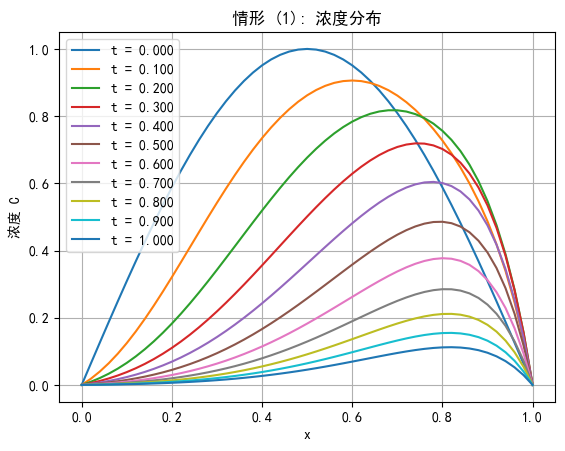

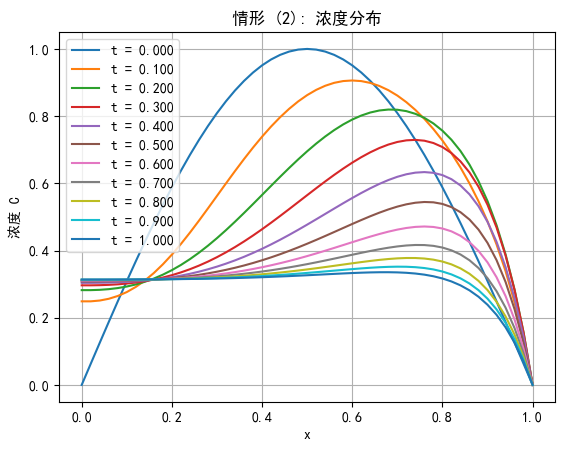

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ----------------------------
# 情形 (1)：两端均为收油装置，即 Dirichlet 边界 C(0,t)=C(l,t)=0
def solve_scenario1(u, D, l, T, Nx, dt, plot_interval=50):
    """
    模型 (1):
      C_t + u C_x = D C_xx,  0<x<l, t>0
      边界: C(0,t)=C(l,t)=0
      初始条件: C(x,0)=sin(pi*x)
      
    每隔 plot_interval 个时间步保存一次浓度分布。
    返回:
      x         -- 空间节点坐标数组
      snapshots -- 一个列表，包含各保存时刻的浓度分布
      times     -- 每个快照对应的时间
    """
    dx = l / Nx
    x = np.linspace(0, l, Nx+1)
    Nt = int(T/dt)
    C = np.sin(np.pi * x)  # 初始条件

    r = D * dt / (dx**2)
    s = u * dt / dx
    N_in = Nx - 1  # 内部节点 i=1,...,Nx-1

    # 构造 Crank-Nicolson 系数矩阵（仅针对内部节点）
    main_A  = (1 + r) * np.ones(N_in)
    lower_A = - (r/2 + s/4) * np.ones(N_in-1)
    upper_A = - (r/2 - s/4) * np.ones(N_in-1)
    A = np.diag(main_A) + np.diag(lower_A, -1) + np.diag(upper_A, 1)

    main_B  = (1 - r) * np.ones(N_in)
    lower_B = (r/2 + s/4) * np.ones(N_in-1)
    upper_B = (r/2 - s/4) * np.ones(N_in-1)
    B = np.diag(main_B) + np.diag(lower_B, -1) + np.diag(upper_B, 1)

    C_in = C[1:-1].copy()

    # 保存初始时刻的快照
    snapshots = [C.copy()]
    times = [0.0]

    # 时间推进
    for n in range(Nt):
        b = B.dot(C_in)
        C_in = np.linalg.solve(A, b)
        C[1:-1] = C_in

        # 每隔 plot_interval 步保存一次当前浓度分布（最后一步也保存）
        if (n+1) % plot_interval == 0 or n == Nt-1:
            snapshots.append(C.copy())
            times.append((n+1)*dt)
    return x, snapshots, times

# ----------------------------
# 情形 (2)：上游固定围油栏（无溢出，Neumann 边界 C_x(0,t)=0），下游收油装置 (Dirichlet C(l,t)=0)
def solve_scenario2(u, D, l, T, Nx, dt, plot_interval=50):
    """
    模型 (2):
      C_t + u C_x = D C_xx,   0<x<l, t>0
      初始条件: C(x,0)=sin(pi*x)
      边界: C_x(0,t)=0（用近似 C(0,t)=C(1,t)）， C(l,t)=0
      
    每隔 plot_interval 个时间步保存一次浓度分布。
    返回:
      x         -- 空间节点坐标数组
      snapshots -- 一个列表，包含各保存时刻的浓度分布
      times     -- 每个快照对应的时间
    """
    dx = l / Nx
    x = np.linspace(0, l, Nx+1)
    Nt = int(T/dt)
    C = np.sin(np.pi * x)

    r = D * dt / (dx**2)
    s = u * dt / dx
    N_in = Nx - 1  # 内部节点 i=1,...,Nx-1

    # 构造系数矩阵——对于 i=1 需要特殊处理（利用 Neumann 边界近似：C(0)=C(1)）
    A = np.zeros((N_in, N_in))
    B = np.zeros((N_in, N_in))
    # i=1 对应矩阵的第 0 行
    A[0,0] = 1 + r - (r/2 + s/4)
    if N_in > 1:
        A[0,1] = - (r/2 - s/4)
    B[0,0] = (1 - r) + (r/2 + s/4)
    if N_in > 1:
        B[0,1] = (r/2 - s/4)
    # 对于 i=2,...,Nx-1
    for j in range(1, N_in):
        A[j,j] = 1 + r
        A[j, j-1] = - (r/2 + s/4)
        if j < N_in - 1:
            A[j, j+1] = - (r/2 - s/4)
        B[j,j] = (1 - r)
        B[j, j-1] = (r/2 + s/4)
        if j < N_in - 1:
            B[j, j+1] = (r/2 - s/4)

    C_in = C[1:-1].copy()

    # 保存初始时刻的快照
    snapshots = [C.copy()]
    times = [0.0]

    # 时间推进
    for n in range(Nt):
        b = B.dot(C_in)
        C_in = np.linalg.solve(A, b)
        C[1:-1] = C_in
        # 强制边界条件：Neumann 在 x=0 处, Dirichlet 在 x=l 处
        C[0] = C[1]
        C[-1] = 0.0

        if (n+1) % plot_interval == 0 or n == Nt-1:
            snapshots.append(C.copy())
            times.append((n+1)*dt)
    return x, snapshots, times

# ----------------------------
# 运行两种情形并在最终静态图中绘出所有时刻的浓度曲线
if __name__ == '__main__':
    # 设置参数
    u = 1.0      # 对流速度
    D = 0.1      # 扩散系数
    l = 1.0      # 空间区间长度
    T = 1.0      # 总模拟时间
    Nx = 50      # 空间离散节点数
    dt = 0.001   # 时间步长
    plot_interval = 100  # 每 100 步保存一次数据

    # 情形 (1)
    x1, snapshots1, times1 = solve_scenario1(u, D, l, T, Nx, dt, plot_interval=plot_interval)
    plt.figure("情形 (1)")
    for snap, t in zip(snapshots1, times1):
        plt.plot(x1, snap, label=f"t = {t:.3f}")
    plt.title("情形 (1): 浓度分布")
    plt.xlabel("x")
    plt.ylabel("浓度 C")
    plt.legend()
    plt.grid(True)

    # 情形 (2)
    x2, snapshots2, times2 = solve_scenario2(u, D, l, T, Nx, dt, plot_interval=plot_interval)
    plt.figure("情形 (2)")
    for snap, t in zip(snapshots2, times2):
        plt.plot(x2, snap, label=f"t = {t:.3f}")
    plt.title("情形 (2): 浓度分布")
    plt.xlabel("x")
    plt.ylabel("浓度 C")
    plt.legend()
    plt.grid(True)

    plt.show()


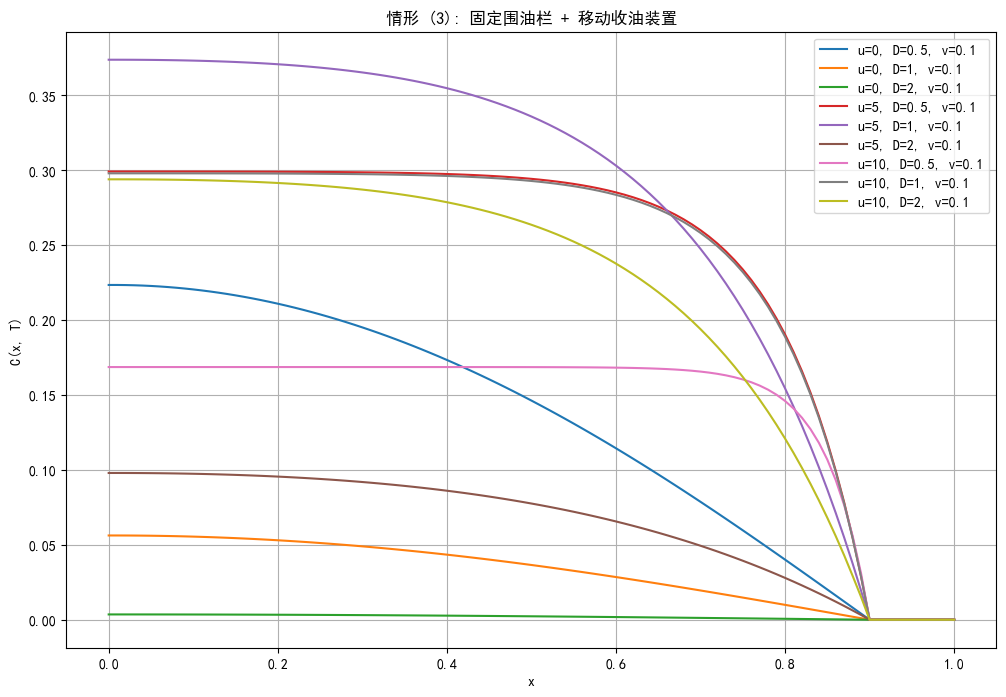

In [18]:
def solve_scenario3(u, D, l, T, Nx, dt, v):
    """
    模型 (3)：
      C_t + u C_x = D C_xx,  t>0,  (实际求解区域为 0<=x<=l_v, 其中 l_v = l - v*t)
      初始: C(x,0)=sin(pi*x) (定义在 0<x<l)
      边界: x=0 处: Neumann,  x=l_v: Dirichlet (C=0)
    """
    dx = l / Nx
    x = np.linspace(0, l, Nx+1)
    Nt = int(T/dt)
    C = np.sin(np.pi * x)  # 初始条件
    
    for n in range(Nt):
        t = n*dt
        # 当前下游边界位置
        x_b = l - v*t
        # 取出最接近 x_b 的网格节点（假设恰好落在网格上）
        i_b = int(round(x_b/dx))
        if i_b < 1:
            i_b = 1
        # 求解区域：节点索引 0 到 i_b
        # 注意：0 处采用 Neumann，即 C[0]=C[1]；i_b 处采用 Dirichlet (C=0)
        N_sub = i_b - 1  # 内部未知数对应 i=1,..., i_b-1
        r = D*dt/(dx**2)
        s = u*dt/dx
        if N_sub > 0:
            A = np.zeros((N_sub, N_sub))
            B = np.zeros((N_sub, N_sub))
            # 对于 i=1（矩阵第 0 行）：利用 Neumann 边界（C_0 = C_1）
            A[0,0] = 1 + r - (r/2 + s/4)
            if N_sub > 1:
                A[0,1] = - (r/2 - s/4)
            B[0,0] = (1 - r) + (r/2 + s/4)
            if N_sub > 1:
                B[0,1] = (r/2 - s/4)
            # 对于 i=2,..., i_b-1
            for j in range(1, N_sub):
                A[j,j] = 1 + r
                A[j, j-1] = - (r/2 + s/4)
                if j < N_sub - 1:
                    A[j, j+1] = - (r/2 - s/4)
                B[j,j] = (1 - r)
                B[j, j-1] = (r/2 + s/4)
                if j < N_sub - 1:
                    B[j, j+1] = (r/2 - s/4)
            C_sub = C[1:i_b].copy()
            rhs = B.dot(C_sub)
            C_sub_new = np.linalg.solve(A, rhs)
            C[1:i_b] = C_sub_new
        # 强制边界条件：Neumann at x=0, Dirichlet at x=i_b
        C[0] = C[1]
        C[i_b] = 0.0
        # 对于 x > x_b 的区域，直接置 0（已被收走）
        if i_b < len(C):
            C[i_b+1:] = 0.0
    return x, C

# 绘图示例：不同 u、D 下的情形 (3)（此处取 v=0.1）
l = 1.0; T = 1.0; Nx = 100; dt = T/1000.0
us = [0, 5, 10]
Ds = [0.5, 1, 2]

v = 0.1  # 收油装置移动速度
plt.figure(figsize=(12,8))
for u in us:
    for D in Ds:
        x, C = solve_scenario3(u, D, l, T, Nx, dt, v)
        label_str = f"u={u}, D={D}, v={v}"
        plt.plot(x, C, label=label_str)
plt.xlabel("x")
plt.ylabel("C(x, T)")
plt.title("情形 (3): 固定围油栏 + 移动收油装置")
plt.legend()
plt.grid(True)
plt.show()


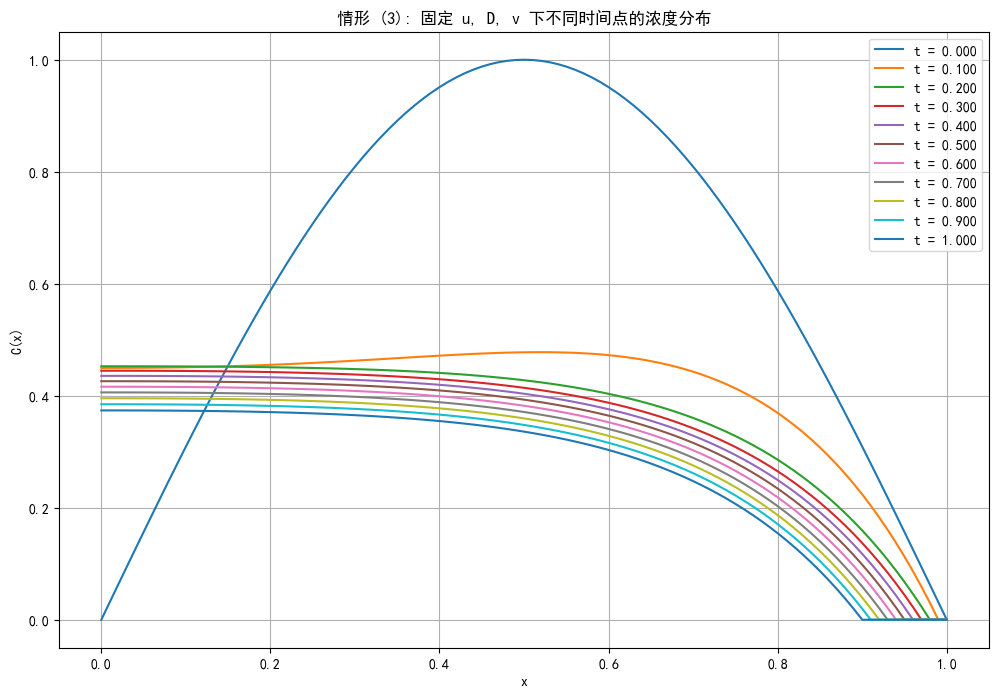

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def solve_scenario3(u, D, l, T, Nx, dt, v, plot_interval=100):
    """
    模型 (3)：
      C_t + u C_x = D C_xx,   t>0
      实际求解区域为 0 <= x <= l_v，其中 l_v = l - v*t
      初始条件：C(x,0)=sin(pi*x)  (定义在 0<=x<=l)
      边界条件：x=0 处采用 Neumann（即 C(0)=C(1)），x=l_v 处采用 Dirichlet（C=0）
      
    参数：
      u, D, v   -- 对流、扩散、收油装置移动速度（固定）
      l, T      -- 空间区间长度和总模拟时间
      Nx, dt    -- 空间离散节点数和时间步长
      plot_interval -- 每隔多少时间步保存一次浓度分布
    返回：
      x         -- 空间节点数组
      snapshots -- 不同时间点的浓度分布列表
      times     -- 对应的时间列表
    """
    dx = l / Nx
    x = np.linspace(0, l, Nx+1)
    Nt = int(T/dt)
    C = np.sin(np.pi * x)  # 初始条件

    # 保存初始状态
    snapshots = [C.copy()]
    times = [0.0]

    for n in range(Nt):
        t = n * dt
        # 当前下游边界位置 x_b = l - v*t
        x_b = l - v * t
        # 取最接近 x_b 的网格节点（假设 x_b 恰好落在网格上，否则取四舍五入后的节点）
        i_b = int(round(x_b / dx))
        if i_b < 1:
            i_b = 1

        # 内部未知数对应节点 i = 1, 2, ..., i_b-1
        N_sub = i_b - 1  
        r = D * dt / (dx**2)
        s = u * dt / dx
        
        if N_sub > 0:
            A = np.zeros((N_sub, N_sub))
            B = np.zeros((N_sub, N_sub))
            # 对于 i = 1（矩阵第 0 行）：利用 Neumann 边界 (C[0]=C[1])
            A[0, 0] = 1 + r - (r/2 + s/4)
            if N_sub > 1:
                A[0, 1] = - (r/2 - s/4)
            B[0, 0] = (1 - r) + (r/2 + s/4)
            if N_sub > 1:
                B[0, 1] = (r/2 - s/4)
            # 对于 i = 2,..., i_b-1
            for j in range(1, N_sub):
                A[j, j] = 1 + r
                A[j, j-1] = - (r/2 + s/4)
                if j < N_sub - 1:
                    A[j, j+1] = - (r/2 - s/4)
                B[j, j] = (1 - r)
                B[j, j-1] = (r/2 + s/4)
                if j < N_sub - 1:
                    B[j, j+1] = (r/2 - s/4)
            # 取内部节点的浓度（i=1 到 i_b-1）
            C_sub = C[1:i_b].copy()
            rhs = B.dot(C_sub)
            C_sub_new = np.linalg.solve(A, rhs)
            C[1:i_b] = C_sub_new

        # 强制边界条件：
        # x=0 处 Neumann: C[0] = C[1]
        C[0] = C[1]
        # x = x_b 处 Dirichlet: C[i_b] = 0
        C[i_b] = 0.0
        # 对于 x > x_b 的区域（已被收走），直接置 0
        if i_b < len(C):
            C[i_b+1:] = 0.0

        # 保存指定时间步的快照
        if (n+1) % plot_interval == 0 or n == Nt-1:
            snapshots.append(C.copy())
            times.append((n+1) * dt)
    
    return x, snapshots, times

# ----------------------------
# 参数设置（固定 u, D, v），并保存不同时间点的浓度分布
l = 1.0
T = 1.0
Nx = 100
dt = T / 1000.0

# 固定的对流速度、扩散系数和收油装置移动速度
u = 5.0
D = 1.0
v = 0.1

plot_interval = 100  # 每 100 步保存一次快照

x, snapshots, times = solve_scenario3(u, D, l, T, Nx, dt, v, plot_interval=plot_interval)

# ----------------------------
# 将不同时间点的浓度曲线全部画在同一张图上
plt.figure(figsize=(12,8))
for snap, t in zip(snapshots, times):
    plt.plot(x, snap, label=f"t = {t:.3f}")
plt.xlabel("x")
plt.ylabel("C(x)")
plt.title("情形 (3): 固定 u, D, v 下不同时间点的浓度分布")
plt.legend()
plt.grid(True)
plt.show()


开始模拟问题1：纯扩散


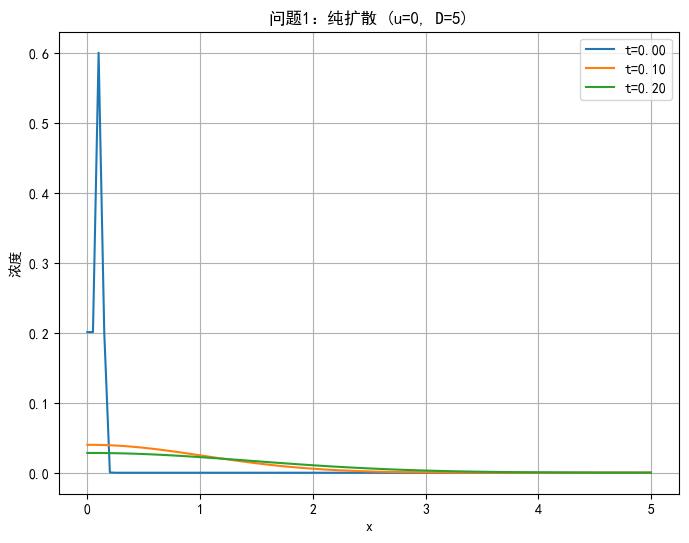

开始模拟问题2：对流—扩散


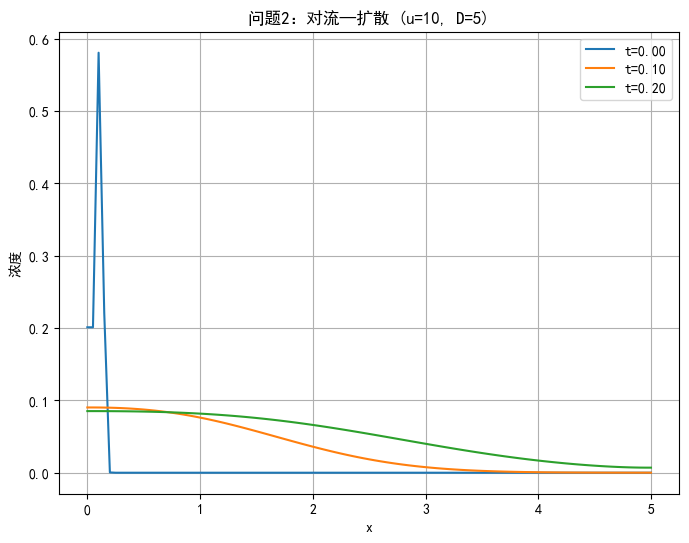

开始模拟问题3：溢油问题（移动下游边界）


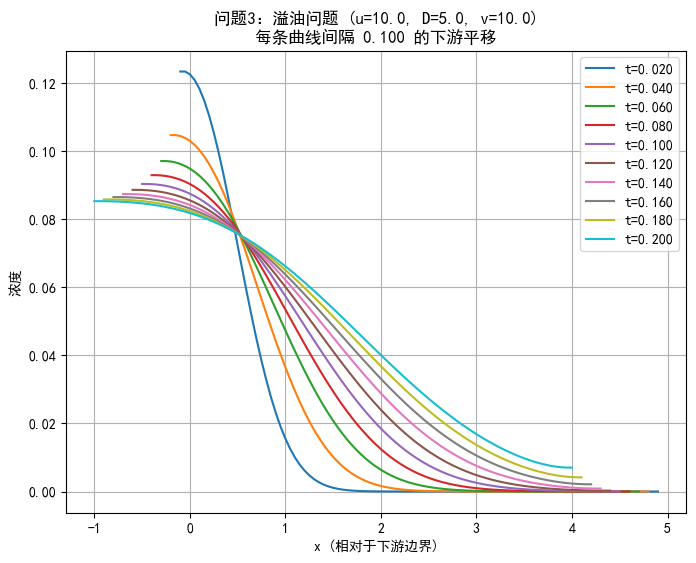

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_problem1(T=0.2, dt=0.0001, dx=0.05):
    """
    问题1：纯扩散问题（u=0）在固定区域内求解
    参数：
      T   : 总模拟时间
      dt  : 时间步长
      dx  : 空间步长
    """
    u = 0.0      # 对流速度为0
    D = 5.0      # 扩散系数

    L = 5.0      # 空间区域长度
    Nx = int(L/dx) + 1
    x = np.linspace(0, L, Nx)
    
    Nt = int(T/dt)
    
    # 初始条件：在靠近 x=0.1 处放置一个窄高斯脉冲
    C = np.exp(-((x - 0.1)/0.02)**2)
    
    # 每隔 0.1 时间单位绘制一次浓度曲线
    plot_interval = int(0.1 / dt)
    
    plt.figure(figsize=(8,6))
    for n in range(Nt):
        # 显式差分格式更新：对流项（这里为0）+ 扩散项
        C_new = C.copy()
        for i in range(1, Nx-1):
            # 对流项（u=0时实际上为0）
            adv = -u * (C[i] - C[i-1]) / dx  
            # 扩散项
            diff = D * (C[i+1] - 2*C[i] + C[i-1]) / dx**2
            C_new[i] = C[i] + dt * (adv + diff)
        # 边界条件：两端用零梯度（Neumann）处理
        C_new[0] = C_new[1]
        C_new[-1] = C_new[-2]
        C = C_new
        
        if (n % plot_interval == 0) or (n == Nt-1):
            plt.plot(x, C, label=f"t={n*dt:.2f}")
    
    plt.xlabel("x")
    plt.ylabel("浓度")
    plt.title("问题1：纯扩散 (u=0, D=5)")
    plt.legend()
    plt.grid(True)
    plt.show()


def simulate_problem2(T=0.2, dt=0.0001, dx=0.05):
    """
    问题2：对流—扩散问题，在固定区域内求解
    参数：
      T   : 总模拟时间
      dt  : 时间步长
      dx  : 空间步长
    """
    u = 10.0     # 对流速度
    D = 5.0      # 扩散系数

    L = 5.0      # 空间区域长度
    Nx = int(L/dx) + 1
    x = np.linspace(0, L, Nx)
    
    Nt = int(T/dt)
    
    # 初始条件：在靠近 x=0.1 处放置一个窄高斯脉冲
    C = np.exp(-((x - 0.1)/0.02)**2)
    
    # 每隔 0.1 时间单位绘制一次浓度曲线
    plot_interval = int(0.1 / dt)
    
    plt.figure(figsize=(8,6))
    for n in range(Nt):
        C_new = C.copy()
        for i in range(1, Nx-1):
            # 对流项采用上风格式
            adv = -u * (C[i] - C[i-1]) / dx
            diff = D * (C[i+1] - 2*C[i] + C[i-1]) / dx**2
            C_new[i] = C[i] + dt * (adv + diff)
        # 边界条件：左端 Neumann，右端视为外流
        C_new[0] = C_new[1]
        C_new[-1] = C_new[-2]
        C = C_new
        
        if (n % plot_interval == 0) or (n == Nt-1):
            plt.plot(x, C, label=f"t={n*dt:.2f}")
    
    plt.xlabel("x")
    plt.ylabel("浓度")
    plt.title("问题2：对流—扩散 (u=10, D=5)")
    plt.legend()
    plt.grid(True)
    plt.show()


def simulate_problem3(T=0.2, dt=0.0001, dx=0.05, shift_per_step=0.0005, plot_every=200):
    """
    问题3：溢油问题（油污染问题）
    模拟时除了按照对流—扩散方程更新浓度外，每个时间步“下游边界”均向下平移一个固定距离，
    并且每经过 plot_every 步（此时累计平移 shift_per_step*plot_every = 0.1），
    绘制一次浓度曲线，以展示随时间（及边界移动）的浓度变化。
    
    参数：
      T             : 总模拟时间
      dt            : 时间步长
      dx            : 空间步长
      shift_per_step: 每个时间步下游边界平移的距离（可根据需要调整）
      plot_every    : 每 plot_every 步绘制一次浓度曲线（此时边界累计移动 shift_per_step*plot_every）
    """
    u = 10.0     # 油相对水的对流速度
    D = 5.0      # 扩散系数
    v = 10.0     # 水流速度（移动边界速度——本例中仅作为参数显示）
    
    L = 5.0      # 初始计算区域长度
    Nx = int(L/dx) + 1
    x = np.linspace(0, L, Nx)
    
    Nt = int(T/dt)
    
    # 初始条件：在靠近 x=0.1 处放置一个窄高斯脉冲，模拟溢油初始分布
    C = np.exp(-((x - 0.1)/0.02)**2)
    
    plt.figure(figsize=(8,6))
    cumulative_shift = 0.0  # 累计的边界移动量
    for n in range(Nt):
        # 使用显式格式更新对流—扩散方程
        C_new = C.copy()
        for i in range(1, Nx-1):
            adv = -u * (C[i] - C[i-1]) / dx
            diff = D * (C[i+1] - 2*C[i] + C[i-1]) / dx**2
            C_new[i] = C[i] + dt * (adv + diff)
        # 边界条件：左侧采用零梯度，右侧采用外流（零梯度）
        C_new[0] = C_new[1]
        C_new[-1] = C_new[-2]
        C = C_new
        
        # 每步更新下游边界的累计平移（这里模拟“移动计算域”）
        cumulative_shift += shift_per_step
        
        # 每 plot_every 步画一次浓度曲线，曲线的 x 坐标按累计平移做调整
        if (n+1) % plot_every == 0 or n == Nt-1:
            plt.plot(x - cumulative_shift, C, label=f"t={(n+1)*dt:.3f}")
    
    plt.xlabel("x (相对于下游边界)")
    plt.ylabel("浓度")
    plt.title(f"问题3：溢油问题 (u={u}, D={D}, v={v})\n每条曲线间隔 {shift_per_step*plot_every:.3f} 的下游平移")
    plt.legend()
    plt.grid(True)
    plt.show()


def main():
    # 依次运行三个问题的模拟，每个问题各自绘制一幅图，展示浓度随时间（或边界移动）的变化
    print("开始模拟问题1：纯扩散")
    simulate_problem1()
    
    print("开始模拟问题2：对流—扩散")
    simulate_problem2()
    
    print("开始模拟问题3：溢油问题（移动下游边界）")
    simulate_problem3()


if __name__ == "__main__":
    main()


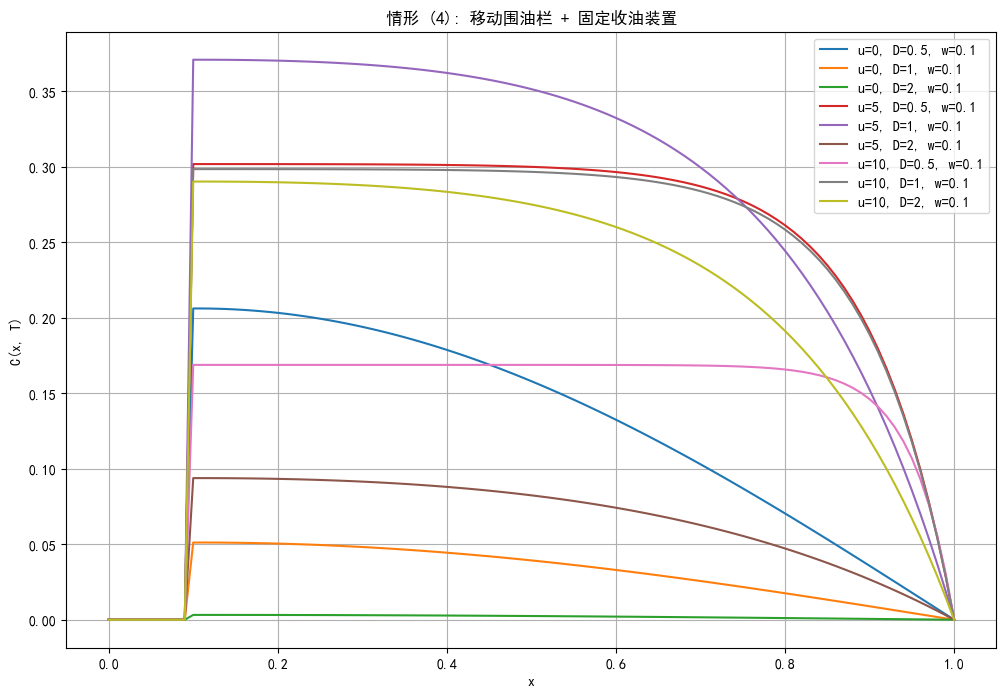

In [10]:
def solve_scenario4(u, D, l, T, Nx, dt, w):
    """
    模型 (4)：
      C_t + u C_x = D C_xx,  t>0,  实际求解区域为 x∈[w*t, l]
      初始: C(x,0)=sin(pi*x)
      边界: x = w*t 处: Neumann (C_x=0),  x = l: Dirichlet (C=0)
    """
    dx = l / Nx
    x = np.linspace(0, l, Nx+1)
    Nt = int(T/dt)
    C = np.sin(np.pi * x)
    
    for n in range(Nt):
        t = n*dt
        # 当前上游边界位置
        x_a = w*t
        i_a = int(round(x_a/dx))
        if i_a > Nx-1:
            i_a = Nx-1
        # 求解区域：节点 i_a 到 Nx，其中 i_a 处 Neumann, i=Nx 处 Dirichlet
        N_sub = Nx - i_a - 1  # 内部未知数对应 i=i_a+1,...,Nx-1
        r = D*dt/(dx**2)
        s = u*dt/dx
        if N_sub > 0:
            A = np.zeros((N_sub, N_sub))
            B = np.zeros((N_sub, N_sub))
            # 对于 i=i_a+1（矩阵第 0 行）：利用 Neumann边界 (C[i_a]=C[i_a+1])
            A[0,0] = 1 + r - (r/2 + s/4)
            if N_sub > 1:
                A[0,1] = - (r/2 - s/4)
            B[0,0] = (1 - r) + (r/2 + s/4)
            if N_sub > 1:
                B[0,1] = (r/2 - s/4)
            for j in range(1, N_sub):
                A[j,j] = 1 + r
                A[j, j-1] = - (r/2 + s/4)
                if j < N_sub - 1:
                    A[j, j+1] = - (r/2 - s/4)
                B[j,j] = (1 - r)
                B[j, j-1] = (r/2 + s/4)
                if j < N_sub - 1:
                    B[j, j+1] = (r/2 - s/4)
            C_sub = C[i_a+1:Nx].copy()
            rhs = B.dot(C_sub)
            C_sub_new = np.linalg.solve(A, rhs)
            C[i_a+1:Nx] = C_sub_new
        # 边界条件：Neumann at x=i_a, Dirichlet at x=Nx
        if i_a < Nx:
            C[i_a] = C[i_a+1]
        C[Nx] = 0.0
        # 对于 x < w*t 的区域，置 0
        if i_a > 0:
            C[:i_a] = 0.0
    return x, C

# 绘图示例：不同 u、D 下的情形 (4)（此处取 w=0.1）
w = 0.1  # 移动围油栏速度
plt.figure(figsize=(12,8))
for u in us:
    for D in Ds:
        x, C = solve_scenario4(u, D, l, T, Nx, dt, w)
        label_str = f"u={u}, D={D}, w={w}"
        plt.plot(x, C, label=label_str)
plt.xlabel("x")
plt.ylabel("C(x, T)")
plt.title("情形 (4): 移动围油栏 + 固定收油装置")
plt.legend()
plt.grid(True)
plt.show()


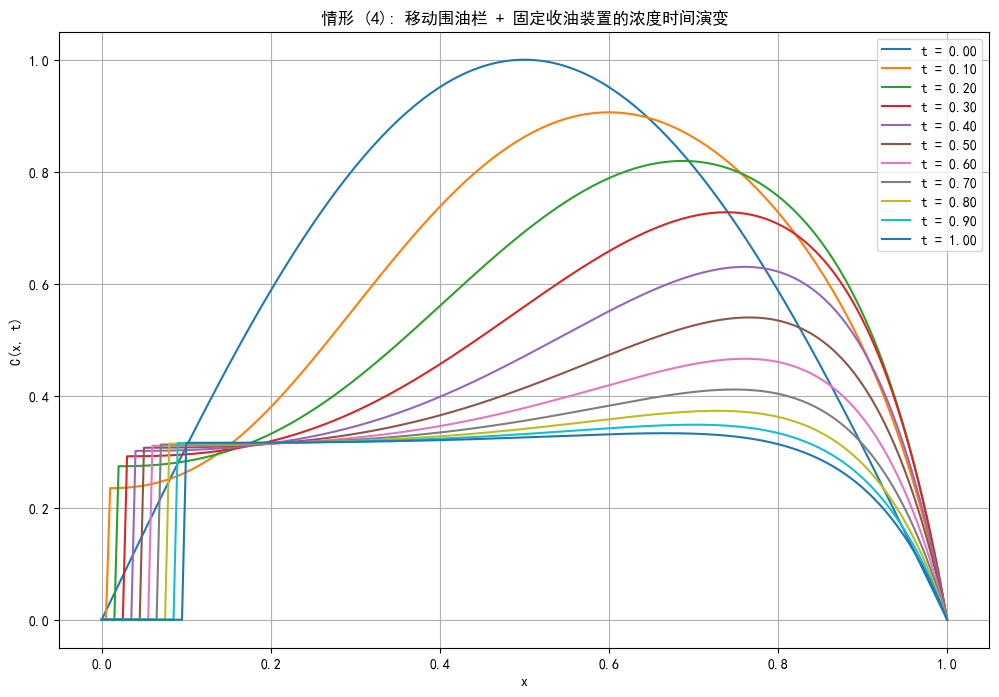

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def solve_scenario4_time_evolution(u, D, l, T, Nx, dt, w, snapshot_interval):
    """
    模型 (4)：
      C_t + u C_x = D C_xx,  t>0,  实际求解区域为 x∈[w*t, l]
      初始条件： C(x,0)=sin(pi*x)
      边界条件： x = w*t 处: Neumann (C_x=0)， x = l: Dirichlet (C=0)
      
    本函数沿时间演进计算，并在每 snapshot_interval 步保存一次浓度分布快照。
    """
    dx = l / Nx
    x = np.linspace(0, l, Nx+1)
    Nt = int(T/dt)
    C = np.sin(np.pi * x)  # 初始条件

    # 用列表存储 (时间, 浓度分布) 快照，初始时刻 t=0
    snapshots = [(0, C.copy())]
    
    for n in range(1, Nt+1):
        t = n * dt
        # 当前上游边界位置
        x_a = w * t
        i_a = int(round(x_a/dx))
        if i_a > Nx-1:
            i_a = Nx-1
        # 求解区域：节点 i_a 到 Nx，其中 i_a 处 Neumann, i=Nx 处 Dirichlet
        N_sub = Nx - i_a - 1  # 内部未知数对应 i=i_a+1,...,Nx-1
        r = D * dt / (dx**2)
        s = u * dt / dx
        
        if N_sub > 0:
            A = np.zeros((N_sub, N_sub))
            B = np.zeros((N_sub, N_sub))
            # 对于 i=i_a+1 (矩阵第 0 行)：利用 Neumann 边界条件 (C[i_a] = C[i_a+1])
            A[0, 0] = 1 + r - (r/2 + s/4)
            if N_sub > 1:
                A[0, 1] = - (r/2 - s/4)
            B[0, 0] = (1 - r) + (r/2 + s/4)
            if N_sub > 1:
                B[0, 1] = (r/2 - s/4)
            for j in range(1, N_sub):
                A[j, j] = 1 + r
                A[j, j-1] = - (r/2 + s/4)
                if j < N_sub - 1:
                    A[j, j+1] = - (r/2 - s/4)
                B[j, j] = (1 - r)
                B[j, j-1] = (r/2 + s/4)
                if j < N_sub - 1:
                    B[j, j+1] = (r/2 - s/4)
            C_sub = C[i_a+1:Nx].copy()
            rhs = B.dot(C_sub)
            C_sub_new = np.linalg.solve(A, rhs)
            C[i_a+1:Nx] = C_sub_new

        # 边界条件：Neumann at x = w*t 处, Dirichlet at x = l
        if i_a < Nx:
            C[i_a] = C[i_a+1]
        C[Nx] = 0.0
        # 对于 x < w*t 的区域，置 0
        if i_a > 0:
            C[:i_a] = 0.0
        
        # 保存快照：每 snapshot_interval 步或最后一步
        if n % snapshot_interval == 0 or n == Nt:
            snapshots.append((t, C.copy()))
    
    return x, snapshots

# 固定参数设置
w = 0.1        # 移动围油栏速度
u = 1.0        # 对流速度
D = 0.1        # 扩散系数
l = 1.0        # 空间区域上界
T = 1.0        # 模拟总时间
Nx = 200       # 空间离散节点数
dt = 0.001     # 时间步长

Nt = int(T/dt)
snapshot_interval = max(1, Nt // 10)  # 例如保存10个快照

# 调用函数获得 x 坐标和各时刻的浓度分布快照
x, snapshots = solve_scenario4_time_evolution(u, D, l, T, Nx, dt, w, snapshot_interval)

# 绘图：绘制不同时间的浓度曲线
plt.figure(figsize=(12, 8))
for t, C in snapshots:
    plt.plot(x, C, label=f"t = {t:.2f}")
plt.xlabel("x")
plt.ylabel("C(x, t)")
plt.title("情形 (4): 移动围油栏 + 固定收油装置的浓度时间演变")
plt.legend()
plt.grid(True)
plt.show()


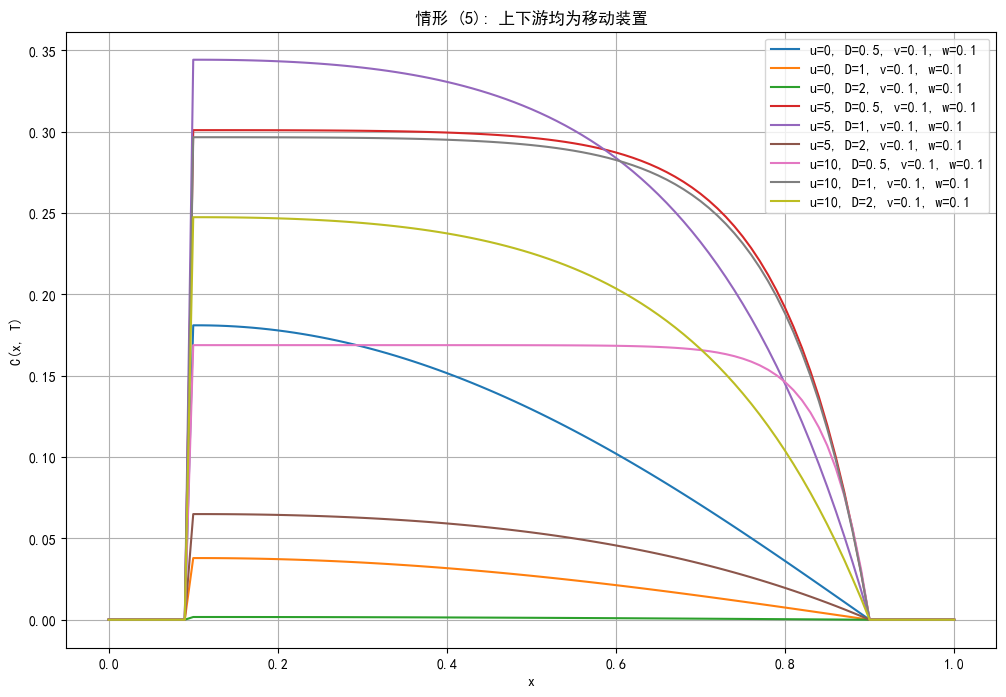

In [12]:
def solve_scenario5(u, D, l, T, Nx, dt, v, w):
    """
    模型 (5)：
      C_t + u C_x = D C_xx,  t>0,  求解区域 x∈[w*t, l-v*t]
      初始: C(x,0)=sin(pi*x)
      边界: x=w*t 处 Neumann,  x=l-v*t 处 Dirichlet (C=0)
    """
    dx = l / Nx
    x = np.linspace(0, l, Nx+1)
    Nt = int(T/dt)
    C = np.sin(np.pi * x)
    
    for n in range(Nt):
        t = n*dt
        x_a = w*t
        x_b = l - v*t
        i_a = int(round(x_a/dx))
        i_b = int(round(x_b/dx))
        if i_a >= i_b:
            # 避免数值上出错
            i_a = 0
            i_b = Nx
        N_sub = i_b - i_a - 1  # 内部未知数对应 i=i_a+1,...,i_b-1
        r = D*dt/(dx**2)
        s = u*dt/dx
        if N_sub > 0:
            A = np.zeros((N_sub, N_sub))
            B = np.zeros((N_sub, N_sub))
            # 对于 i=i_a+1
            A[0,0] = 1 + r - (r/2 + s/4)
            if N_sub > 1:
                A[0,1] = - (r/2 - s/4)
            B[0,0] = (1 - r) + (r/2 + s/4)
            if N_sub > 1:
                B[0,1] = (r/2 - s/4)
            for j in range(1, N_sub):
                A[j,j] = 1 + r
                A[j, j-1] = - (r/2 + s/4)
                if j < N_sub - 1:
                    A[j, j+1] = - (r/2 - s/4)
                B[j,j] = (1 - r)
                B[j, j-1] = (r/2 + s/4)
                if j < N_sub - 1:
                    B[j, j+1] = (r/2 - s/4)
            C_sub = C[i_a+1:i_b].copy()
            rhs = B.dot(C_sub)
            C_sub_new = np.linalg.solve(A, rhs)
            C[i_a+1:i_b] = C_sub_new
        # 强制边界条件
        if i_a < len(C)-1:
            C[i_a] = C[i_a+1]   # Neumann at左边界
        C[i_b] = 0.0           # Dirichlet at右边界
        # 区域外置 0
        if i_a > 0:
            C[:i_a] = 0.0
        if i_b < len(C)-1:
            C[i_b+1:] = 0.0
    return x, C

# 绘图示例：固定参数下（取 v=w=0.1），不同 u、D 对情形 (5) 的影响
v = 0.1; w = 0.1
plt.figure(figsize=(12,8))
for u in us:
    for D in Ds:
        x, C = solve_scenario5(u, D, l, T, Nx, dt, v, w)
        label_str = f"u={u}, D={D}, v={v}, w={w}"
        plt.plot(x, C, label=label_str)
plt.xlabel("x")
plt.ylabel("C(x, T)")
plt.title("情形 (5): 上下游均为移动装置")
plt.legend()
plt.grid(True)
plt.show()


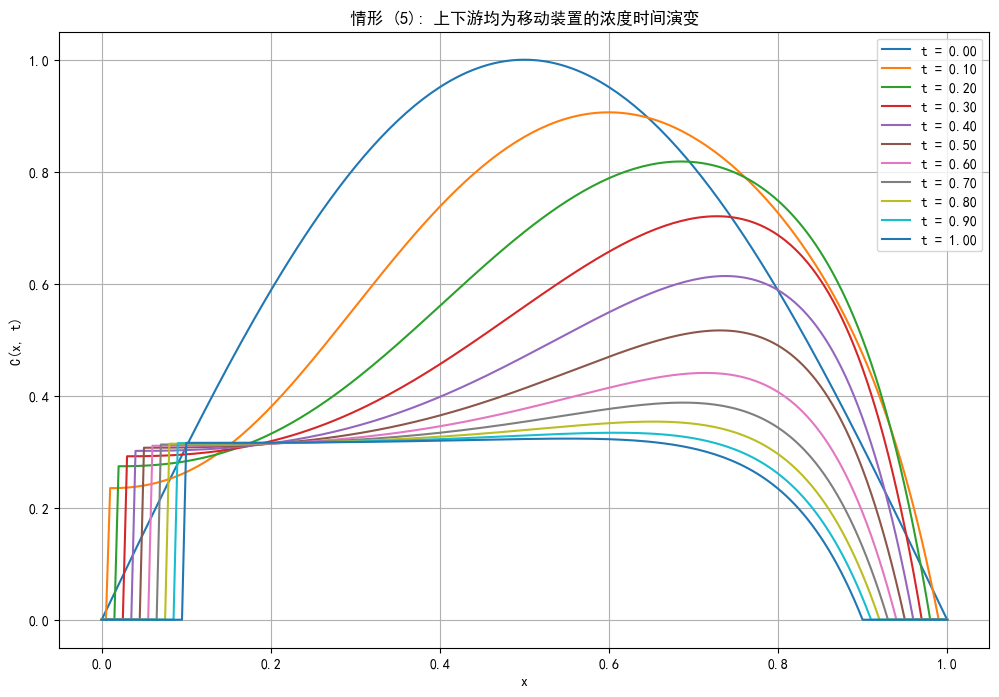

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def solve_scenario5_time_evolution(u, D, l, T, Nx, dt, v, w, snapshot_interval):
    """
    模型 (5)：
      C_t + u C_x = D C_xx,  t>0,  求解区域 x∈[w*t, l-v*t]
      初始条件： C(x,0)=sin(pi*x)
      边界条件：左边界 x=w*t 处采用 Neumann (C_x=0)，右边界 x=l-v*t 处采用 Dirichlet (C=0)
      
    本函数沿时间演进计算，并在每 snapshot_interval 步保存一次浓度分布快照。
    """
    dx = l / Nx
    x = np.linspace(0, l, Nx+1)
    Nt = int(T/dt)
    C = np.sin(np.pi * x)  # 初始条件

    # 用列表保存 (时间, 浓度分布) 快照，初始时刻 t=0
    snapshots = [(0, C.copy())]
    
    for n in range(1, Nt+1):
        t = n * dt
        # 当前左右边界位置
        x_a = w * t        # 左边界位置
        x_b = l - v * t    # 右边界位置
        i_a = int(round(x_a / dx))
        i_b = int(round(x_b / dx))
        if i_a >= i_b:
            # 避免数值上出错
            i_a = 0
            i_b = Nx
        # 内部未知数对应 i=i_a+1,...,i_b-1
        N_sub = i_b - i_a - 1
        r = D * dt / (dx**2)
        s = u * dt / dx
        
        if N_sub > 0:
            A = np.zeros((N_sub, N_sub))
            B = np.zeros((N_sub, N_sub))
            # 对于 i=i_a+1 处，利用左边 Neumann 条件 (C[i_a]=C[i_a+1])
            A[0, 0] = 1 + r - (r/2 + s/4)
            if N_sub > 1:
                A[0, 1] = - (r/2 - s/4)
            B[0, 0] = (1 - r) + (r/2 + s/4)
            if N_sub > 1:
                B[0, 1] = (r/2 - s/4)
            for j in range(1, N_sub):
                A[j, j] = 1 + r
                A[j, j-1] = - (r/2 + s/4)
                if j < N_sub - 1:
                    A[j, j+1] = - (r/2 - s/4)
                B[j, j] = (1 - r)
                B[j, j-1] = (r/2 + s/4)
                if j < N_sub - 1:
                    B[j, j+1] = (r/2 - s/4)
            # 取内部节点的当前浓度分布
            C_sub = C[i_a+1:i_b].copy()
            rhs = B.dot(C_sub)
            C_sub_new = np.linalg.solve(A, rhs)
            C[i_a+1:i_b] = C_sub_new

        # 强制边界条件
        if i_a < len(C)-1:
            C[i_a] = C[i_a+1]   # 左边 Neumann 条件
        C[i_b] = 0.0           # 右边 Dirichlet 条件
        
        # 区域外浓度置 0
        if i_a > 0:
            C[:i_a] = 0.0
        if i_b < len(C)-1:
            C[i_b+1:] = 0.0
        
        # 保存快照：每 snapshot_interval 步或最后一步
        if n % snapshot_interval == 0 or n == Nt:
            snapshots.append((t, C.copy()))
    
    return x, snapshots

# 固定参数设置
w = 0.1        # 左侧移动边界速度
v = 0.1        # 右侧移动边界速度
u = 1.0        # 对流速度
D = 0.1        # 扩散系数
l = 1.0        # 空间区域上界
T = 1.0        # 模拟总时间
Nx = 200       # 空间离散节点数
dt = 0.001     # 时间步长

Nt = int(T/dt)
snapshot_interval = max(1, Nt // 10)  # 保存10个快照

# 调用函数获得 x 坐标和各时刻的浓度分布快照
x, snapshots = solve_scenario5_time_evolution(u, D, l, T, Nx, dt, v, w, snapshot_interval)

# 绘图：绘制不同时间的浓度曲线
plt.figure(figsize=(12, 8))
for t, C in snapshots:
    plt.plot(x, C, label=f"t = {t:.2f}")
plt.xlabel("x")
plt.ylabel("C(x, t)")
plt.title("情形 (5): 上下游均为移动装置的浓度时间演变")
plt.legend()
plt.grid(True)
plt.show()


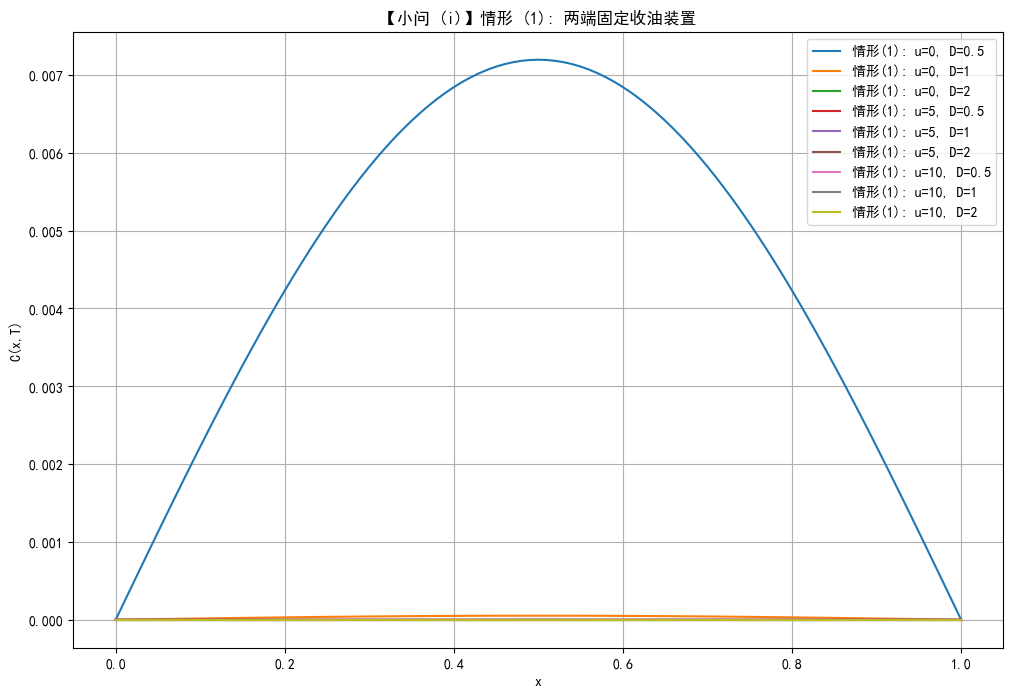

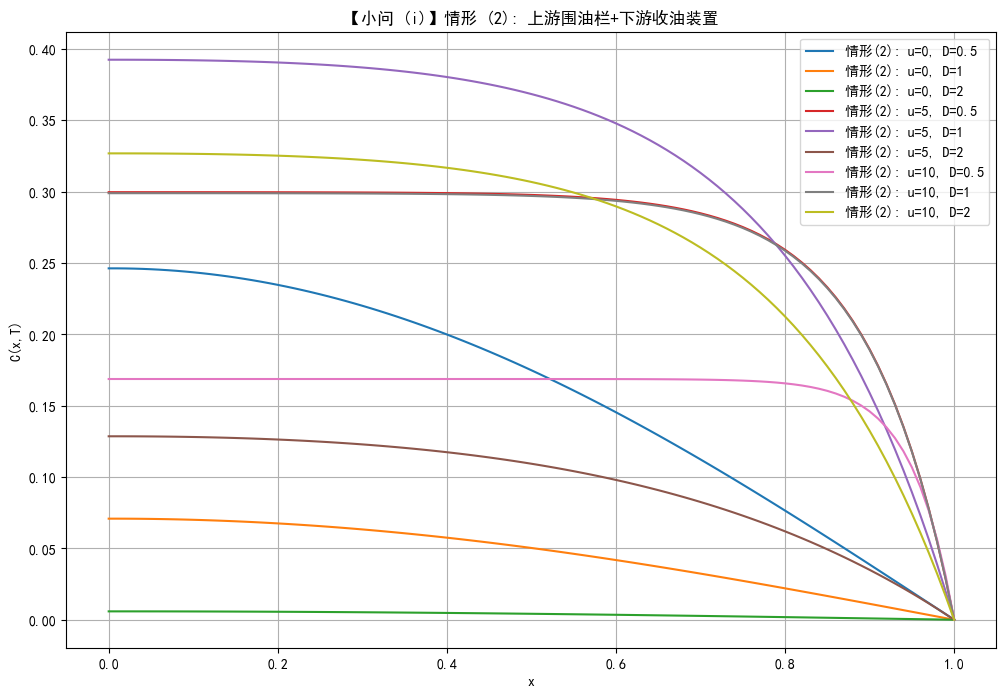

In [14]:
# 取 l=1, T=1, Nx=100, dt=T/1000
l = 1.0; T = 1.0; Nx = 100; dt = T/1000.0
us = [0, 5, 10]
Ds = [0.5, 1, 2]  # 可根据需要选取不同 D

plt.figure(figsize=(12,8))
for u in us:
    for D in Ds:
        x, C = solve_scenario1(u, D, l, T, Nx, dt)
        label_str = f"情形(1): u={u}, D={D}"
        plt.plot(x, C, label=label_str)
plt.xlabel("x")
plt.ylabel("C(x,T)")
plt.title("【小问 (i)】情形 (1): 两端固定收油装置")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,8))
for u in us:
    for D in Ds:
        x, C = solve_scenario2(u, D, l, T, Nx, dt)
        label_str = f"情形(2): u={u}, D={D}"
        plt.plot(x, C, label=label_str)
plt.xlabel("x")
plt.ylabel("C(x,T)")
plt.title("【小问 (i)】情形 (2): 上游围油栏+下游收油装置")
plt.legend()
plt.grid(True)
plt.show()


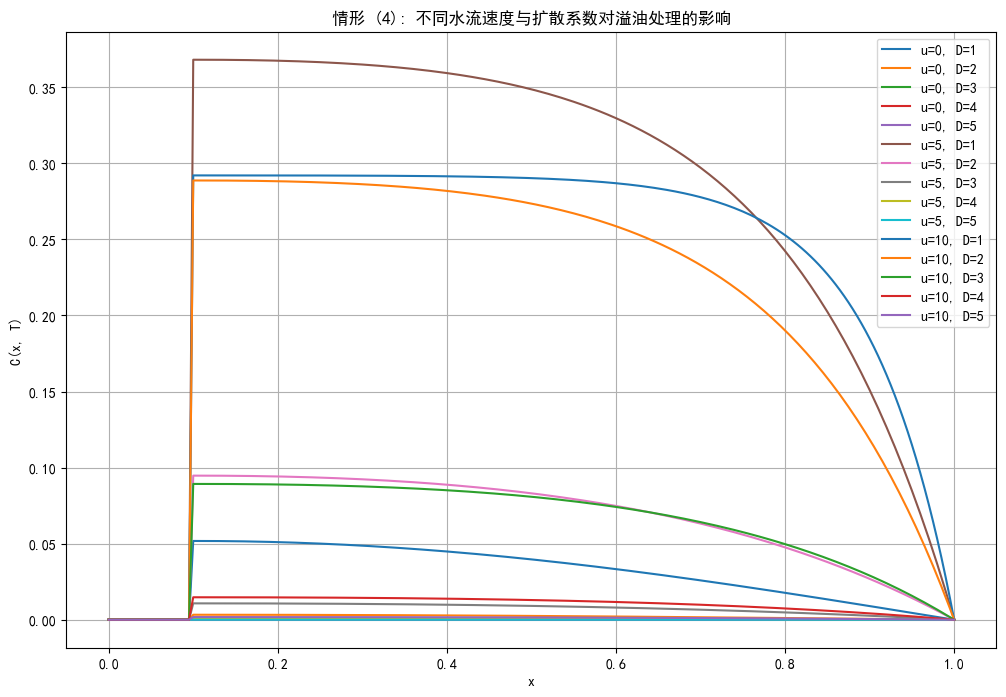

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def solve_scenario4(u, D, l, T, Nx, dt, w):
    """
    模型 (4)：
      C_t + u C_x = D C_xx,  t>0,  求解区域 x∈[w*t, l]
      初始条件： C(x,0)=sin(pi*x)
      边界条件： x = w*t 处采用 Neumann (C_x=0)，x = l 处 Dirichlet (C=0)
    """
    dx = l / Nx
    x = np.linspace(0, l, Nx+1)
    Nt = int(T / dt)
    C = np.sin(np.pi * x)  # 初始条件

    for n in range(Nt):
        t = n * dt
        # 当前上游边界位置
        x_a = w * t
        i_a = int(round(x_a / dx))
        if i_a > Nx - 1:
            i_a = Nx - 1
        # 求解区域：节点 i_a 到 Nx，其中 i_a 处 Neumann, i=Nx 处 Dirichlet
        N_sub = Nx - i_a - 1  # 内部未知数对应 i=i_a+1,...,Nx-1
        r = D * dt / (dx ** 2)
        s = u * dt / dx
        if N_sub > 0:
            A = np.zeros((N_sub, N_sub))
            B = np.zeros((N_sub, N_sub))
            # 对于 i=i_a+1 处，利用左边 Neumann 条件 (C[i_a]=C[i_a+1])
            A[0, 0] = 1 + r - (r / 2 + s / 4)
            if N_sub > 1:
                A[0, 1] = - (r / 2 - s / 4)
            B[0, 0] = (1 - r) + (r / 2 + s / 4)
            if N_sub > 1:
                B[0, 1] = (r / 2 - s / 4)
            for j in range(1, N_sub):
                A[j, j] = 1 + r
                A[j, j - 1] = - (r / 2 + s / 4)
                if j < N_sub - 1:
                    A[j, j + 1] = - (r / 2 - s / 4)
                B[j, j] = (1 - r)
                B[j, j - 1] = (r / 2 + s / 4)
                if j < N_sub - 1:
                    B[j, j + 1] = (r / 2 - s / 4)
            C_sub = C[i_a + 1:Nx].copy()
            rhs = B.dot(C_sub)
            C_sub_new = np.linalg.solve(A, rhs)
            C[i_a + 1:Nx] = C_sub_new
        # 边界条件处理
        if i_a < Nx:
            C[i_a] = C[i_a + 1]
        C[Nx] = 0.0
        # 区域外浓度置 0
        if i_a > 0:
            C[:i_a] = 0.0
    return x, C

# 参数设置
l = 1.0      # 空间域上界
T = 1.0      # 模拟总时间
Nx = 200     # 空间节点数
dt = 0.001   # 时间步长
w = 0.1      # 固定的围油栏移动速度

# 不同水流速度和扩散系数的取值
us = [0, 5, 10]
Ds = [1, 2, 3, 4, 5]

plt.figure(figsize=(12, 8))
for u in us:
    for D in Ds:
        x, C = solve_scenario4(u, D, l, T, Nx, dt, w)
        label_str = f"u={u}, D={D}"
        plt.plot(x, C, label=label_str)
plt.xlabel("x")
plt.ylabel("C(x, T)")
plt.title("情形 (4): 不同水流速度与扩散系数对溢油处理的影响")
plt.legend()
plt.grid(True)
plt.show()


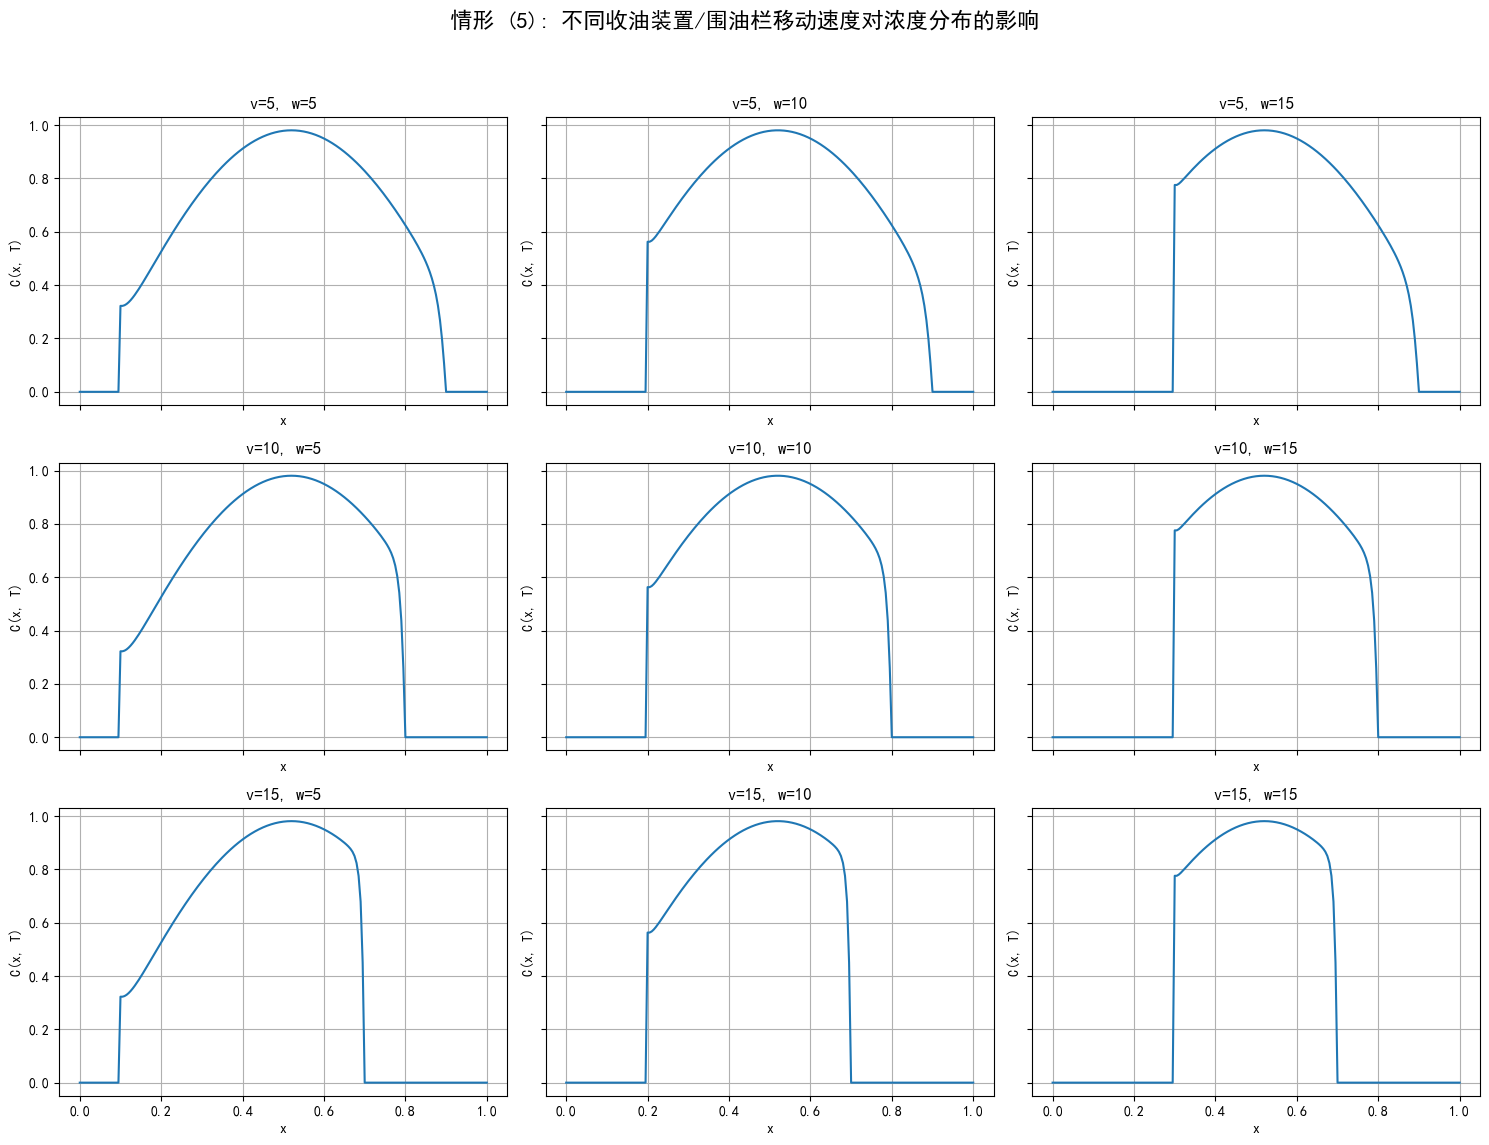

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def solve_scenario5(u, D, l, T, Nx, dt, v, w):
    """
    模型 (5)：
      C_t + u C_x = D C_xx,  t>0,  求解区域 x∈[w*t, l-v*t]
      初始条件： C(x,0)=sin(pi*x)
      边界条件：左边界 x=w*t 处采用 Neumann (C_x=0)，右边界 x=l-v*t 处 Dirichlet (C=0)
    """
    dx = l / Nx
    x = np.linspace(0, l, Nx+1)
    Nt = int(T / dt)
    C = np.sin(np.pi * x)

    for n in range(Nt):
        t = n * dt
        # 当前左右边界位置
        x_a = w * t        # 左边界
        x_b = l - v * t    # 右边界
        i_a = int(round(x_a / dx))
        i_b = int(round(x_b / dx))
        if i_a >= i_b:
            # 避免数值计算出错
            i_a = 0
            i_b = Nx
        N_sub = i_b - i_a - 1  # 内部未知数对应 i=i_a+1,...,i_b-1
        r = D * dt / (dx ** 2)
        s = u * dt / dx
        if N_sub > 0:
            A = np.zeros((N_sub, N_sub))
            B = np.zeros((N_sub, N_sub))
            # 对于 i=i_a+1 处，利用左边 Neumann 条件 (C[i_a]=C[i_a+1])
            A[0, 0] = 1 + r - (r / 2 + s / 4)
            if N_sub > 1:
                A[0, 1] = - (r / 2 - s / 4)
            B[0, 0] = (1 - r) + (r / 2 + s / 4)
            if N_sub > 1:
                B[0, 1] = (r / 2 - s / 4)
            for j in range(1, N_sub):
                A[j, j] = 1 + r
                A[j, j - 1] = - (r / 2 + s / 4)
                if j < N_sub - 1:
                    A[j, j + 1] = - (r / 2 - s / 4)
                B[j, j] = (1 - r)
                B[j, j - 1] = (r / 2 + s / 4)
                if j < N_sub - 1:
                    B[j, j + 1] = (r / 2 - s / 4)
            C_sub = C[i_a + 1:i_b].copy()
            rhs = B.dot(C_sub)
            C_sub_new = np.linalg.solve(A, rhs)
            C[i_a + 1:i_b] = C_sub_new
        # 强制边界条件
        if i_a < len(C) - 1:
            C[i_a] = C[i_a + 1]   # 左边 Neumann
        C[i_b] = 0.0             # 右边 Dirichlet
        # 区域外浓度置 0
        if i_a > 0:
            C[:i_a] = 0.0
        if i_b < len(C) - 1:
            C[i_b + 1:] = 0.0
    return x, C

# 参数设置
u = 1.0      # 水流速度
D = 0.1      # 扩散系数
l = 1.0      # 空间域上界
T = 0.02     # 总模拟时间（为保证较大移动速度下边界不碰撞，T取较小值）
Nx = 200     # 空间节点数
dt = 0.0001  # 时间步长

v_values = [5, 10, 15]  # 右侧收油装置的移动速度
w_values = [5, 10, 15]  # 左侧围油栏的移动速度

# 利用子图展示不同 v 和 w 组合下的结果
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)
for i, v in enumerate(v_values):
    for j, w in enumerate(w_values):
        x, C = solve_scenario5(u, D, l, T, Nx, dt, v, w)
        ax = axes[i, j]
        ax.plot(x, C)
        ax.set_title(f"v={v}, w={w}")
        ax.set_xlabel("x")
        ax.set_ylabel("C(x, T)")
        ax.grid(True)

fig.suptitle("情形 (5): 不同收油装置/围油栏移动速度对浓度分布的影响", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


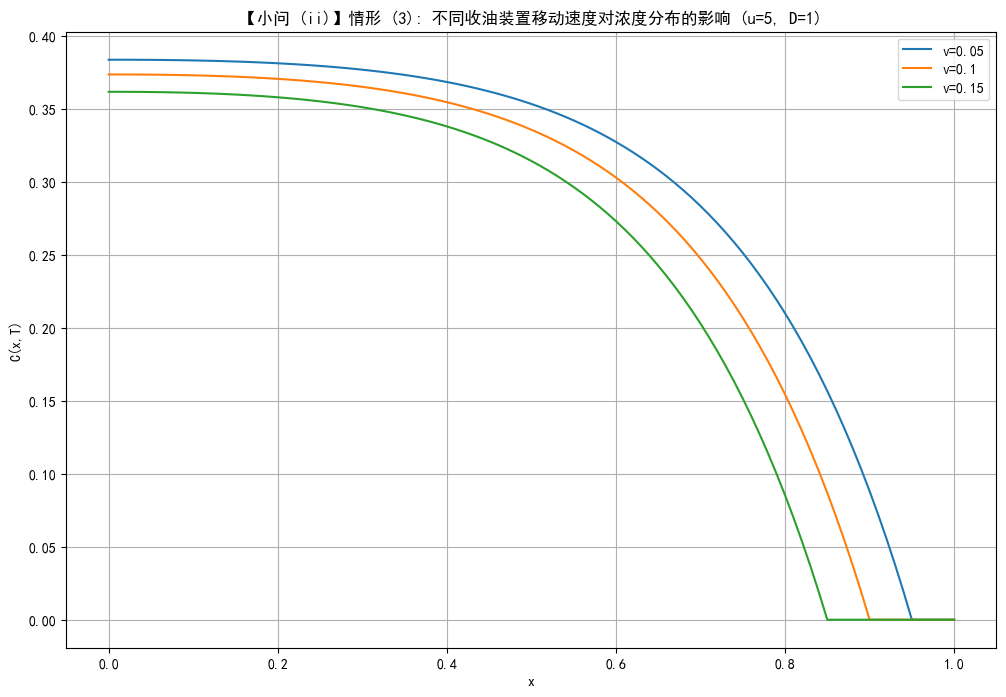

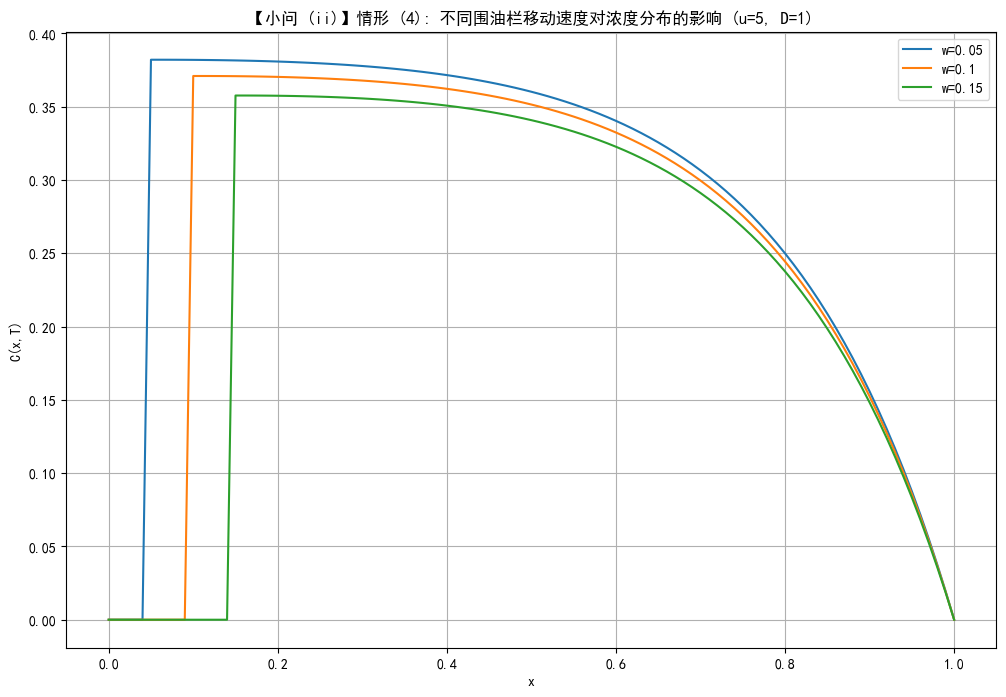

In [16]:
# 情形 (3)：考察不同 v 值对结果的影响（固定 u=5, D=1）
v_values = [0.05, 0.1, 0.15]
u_val = 5; D_val = 1
plt.figure(figsize=(12,8))
for v_val in v_values:
    x, C = solve_scenario3(u_val, D_val, l, T, Nx, dt, v_val)
    label_str = f"v={v_val}"
    plt.plot(x, C, label=label_str)
plt.xlabel("x")
plt.ylabel("C(x,T)")
plt.title("【小问 (ii)】情形 (3): 不同收油装置移动速度对浓度分布的影响 (u=5, D=1)")
plt.legend()
plt.grid(True)
plt.show()

# 情形 (4)：考察不同 w 值对结果的影响（固定 u=5, D=1）
w_values = [0.05, 0.1, 0.15]
plt.figure(figsize=(12,8))
for w_val in w_values:
    x, C = solve_scenario4(u_val, D_val, l, T, Nx, dt, w_val)
    label_str = f"w={w_val}"
    plt.plot(x, C, label=label_str)
plt.xlabel("x")
plt.ylabel("C(x,T)")
plt.title("【小问 (ii)】情形 (4): 不同围油栏移动速度对浓度分布的影响 (u=5, D=1)")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
def total_oil(x, C):
    dx = x[1]-x[0]
    return np.sum(C)*dx

# 选取固定参数： u=5, D=1, l=1, T=1, Nx=100, dt=T/1000, 移动速度取 0.1
params = dict(u=5, D=1, l=l, T=T, Nx=Nx, dt=dt, v=0.1, w=0.1)
solvers = {
    "情形 (1): 固定收油装置": lambda: solve_scenario1(params["u"], params["D"], l, T, Nx, dt),
    "情形 (2): 上游围油栏 + 下游收油装置": lambda: solve_scenario2(params["u"], params["D"], l, T, Nx, dt),
    "情形 (3): 固定围油栏 + 移动收油装置": lambda: solve_scenario3(params["u"], params["D"], l, T, Nx, dt, params["v"]),
    "情形 (4): 移动围油栏 + 固定收油装置": lambda: solve_scenario4(params["u"], params["D"], l, T, Nx, dt, params["w"]),
    "情形 (5): 上下游均移动": lambda: solve_scenario5(params["u"], params["D"], l, T, Nx, dt, params["v"], params["w"])
}

print("【小问 (iii)】各情形下最终时刻剩余油量：")
for name, solver in solvers.items():
    x, C = solver()
    oil = total_oil(x, C)
    print(f"{name}: 总油量 = {oil:.4e}")


【小问 (iii)】各情形下最终时刻剩余油量：
情形 (1): 固定收油装置: 总油量 = 8.1522e-08
情形 (2): 上游围油栏 + 下游收油装置: 总油量 = 3.2249e-01
情形 (3): 固定围油栏 + 移动收油装置: 总油量 = 2.7265e-01
情形 (4): 移动围油栏 + 固定收油装置: 总油量 = 2.7005e-01
情形 (5): 上下游均移动: 总油量 = 2.1928e-01


C:\Users\Administrator\AppData\Local\Temp\ipykernel_32280\924370254.py:59: RuntimeWarning: overflow encountered in scalar divide
  diffusive = D * (C[i+1] - 2*C[i] + C[i-1]) / dx**2
C:\Users\Administrator\AppData\Local\Temp\ipykernel_32280\924370254.py:60: RuntimeWarning: invalid value encountered in scalar add
  C_new[i] = C[i] + dt * (convective + diffusive)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_32280\924370254.py:58: RuntimeWarning: invalid value encountered in scalar subtract
  convective = -u * (C[i] - C[i-1]) / dx
C:\Users\Administrator\AppData\Local\Temp\ipykernel_32280\924370254.py:59: RuntimeWarning: invalid value encountered in scalar add
  diffusive = D * (C[i+1] - 2*C[i] + C[i-1]) / dx**2
C:\Users\Administrator\AppData\Local\Temp\ipykernel_32280\924370254.py:59: RuntimeWarning: invalid value encountered in scalar subtract
  diffusive = D * (C[i+1] - 2*C[i] + C[i-1]) / dx**2


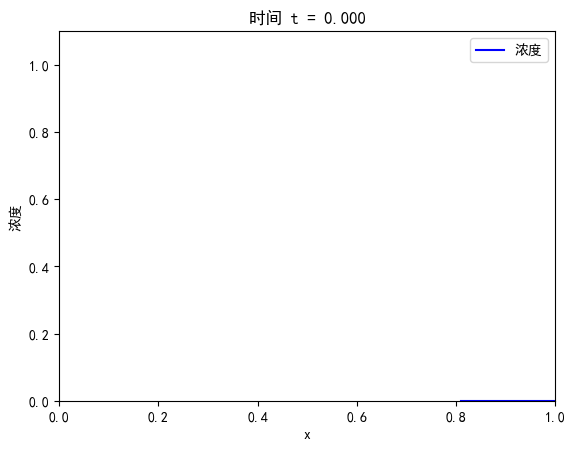

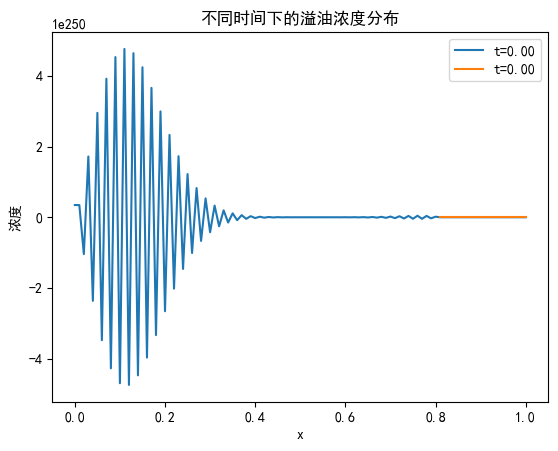

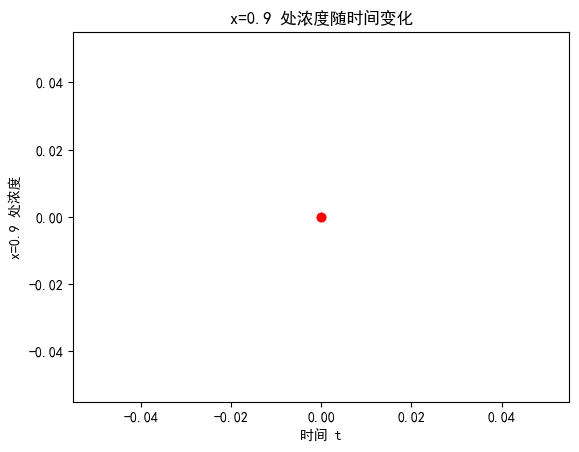

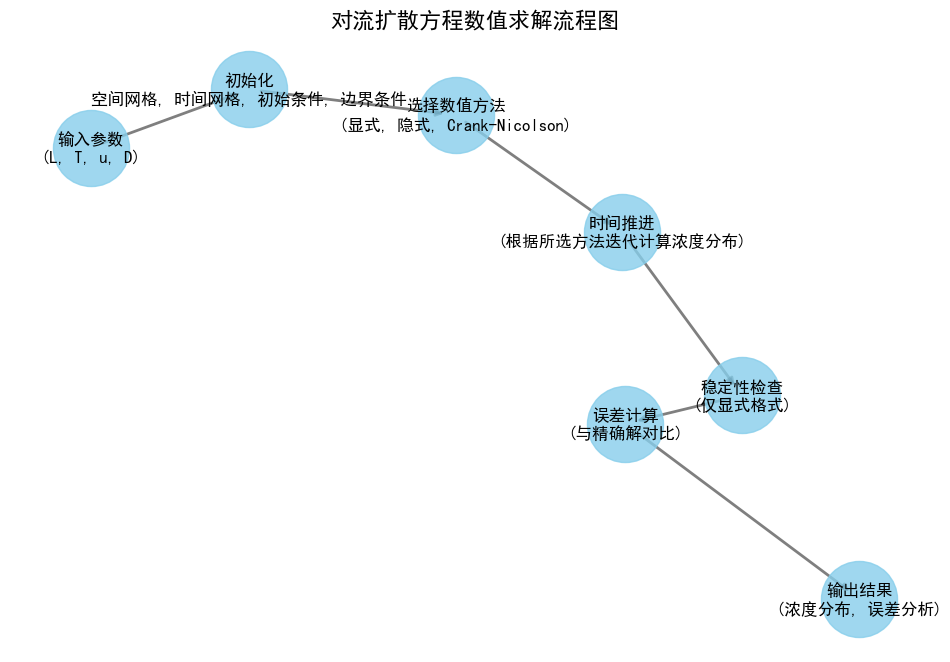

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx

plt.rcParams['font.sans-serif'] = ['SimHei']	# 显示中文
plt.rcParams['axes.unicode_minus'] = False		# 显示负号

G = nx.DiGraph()

nodes = [
    "输入参数\n(L, T, u, D)",
    "初始化\n空间网格, 时间网格, 初始条件, 边界条件",
    "选择数值方法\n(显式, 隐式, Crank-Nicolson)",
    "时间推进\n(根据所选方法迭代计算浓度分布)",
    "稳定性检查\n(仅显式格式)",
    "误差计算\n(与精确解对比)",
    "输出结果\n(浓度分布, 误差分析)"
]

G.add_nodes_from(nodes)

edges = [
    ("输入参数\n(L, T, u, D)", "初始化\n空间网格, 时间网格, 初始条件, 边界条件"),
    ("初始化\n空间网格, 时间网格, 初始条件, 边界条件", "选择数值方法\n(显式, 隐式, Crank-Nicolson)"),
    ("选择数值方法\n(显式, 隐式, Crank-Nicolson)", "时间推进\n(根据所选方法迭代计算浓度分布)"),
    ("时间推进\n(根据所选方法迭代计算浓度分布)", "稳定性检查\n(仅显式格式)"),
    ("稳定性检查\n(仅显式格式)", "误差计算\n(与精确解对比)"),
    ("误差计算\n(与精确解对比)", "输出结果\n(浓度分布, 误差分析)")
]

G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))

nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, alpha=0.5, edge_color='black')
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif', font_weight='bold', font_color='black')

plt.title('对流扩散方程数值求解流程图', fontsize=16)
plt.axis('off')
plt.show()
